In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from  scipy.interpolate import interp1d
import json
import itertools
import numpy as np                          
import pandas as pd
import matplotlib.pyplot as plt
#https://github.com/PyCOMPLETE/FillingPatterns       
import fillingpatterns as fp   
from scipy.interpolate import RegularGridInterpolator as rgi
import matplotlib.dates as mdates
from scipy.constants import c as clight

params = {'xtick.labelsize': 15,
'ytick.labelsize': 22,
'font.size': 20,
'figure.autolayout': True,
'figure.figsize': (10, 8),
'axes.titlesize' : 26,
'axes.labelsize' : 26,
'lines.linewidth' : 4,
'lines.markersize' : 12,
'legend.fontsize': 15,
'mathtext.fontset': 'stix',
'font.family': 'STIXGeneral'}
plt.rcParams.update(params)

# Find which fills made it to 30 cm, with more than 2000 bunches and that lasted more than 8 hours

In [2]:
data_2023 = "/eos/project/l/lhc-lumimod/LuminosityFollowUp/2023/procdata/"

def find_folders_with_stable(root_path):
    folders_with_stable = []

    for dirpath, dirnames, filenames in os.walk(root_path):
        if any("STABLE" in foldername for foldername in dirnames):
            
            folders_with_stable.append(dirpath)

    return folders_with_stable

def find_parquet_files(folders):
    parquet_files = []

    for folder in folders:
        for dirpath, dirnames, filenames in os.walk(folder):
            for filename in filenames:
                if filename.endswith(".parquet"):
                    parquet_files.append(os.path.join(dirpath, filename))

    return parquet_files


remove_fills = [8898]

stable_folders = find_folders_with_stable(data_2023)
filtered_stable_folders = [folder for folder in stable_folders if not any(str(filln) in folder for filln in remove_fills)]

parquet_files = find_parquet_files(filtered_stable_folders)
parquet_files_stable = [i for i in parquet_files if "STABLE" in i]
parquet_files_inj = [i for i in parquet_files if "INJPHYS" in i]


filln_numbers = [int(re.search(r'FILLN=(\d+)', path).group(1)) for path in parquet_files_stable if re.search(r'FILLN=(\d+)', path)]
df_fills = pd.DataFrame({"fill": filln_numbers, "SB path": parquet_files_stable, "INJ path": parquet_files_inj})
df_fills.set_index("fill", inplace=True)

df_fills = df_fills[df_fills.index<9192] # ions start after fill 9192

def get_min_beta_star(x):
    beta_steps = pd.read_parquet(x["SB path"], columns=["HX:BETASTAR_IP1"])
    if beta_steps.min().values[0]>0:
        return beta_steps.min().values[0]
    else:
        return np.sort(beta_steps["HX:BETASTAR_IP1"].unique())[1]
    
def get_max_bunches(x):
    return pd.read_parquet(x["SB path"], columns = ["LHC.BQM.B1:NO_BUNCHES"]).max().values[0]

def get_duration(x):
    beta_steps = pd.read_parquet(x["SB path"], columns=["HX:BETASTAR_IP1"])
    return (pd.Timestamp(beta_steps.index[-1])-pd.Timestamp(beta_steps.index[0])).seconds/3600.0

def get_start(x):
    beta_steps = pd.read_parquet(x["SB path"], columns=["HX:BETASTAR_IP1"])
    return (pd.Timestamp(beta_steps.index[0]))

def get_end(x):
    beta_steps = pd.read_parquet(x["SB path"], columns=["HX:BETASTAR_IP1"])
    return (pd.Timestamp(beta_steps.index[-1]))
    
df_fills["IP1 beta min"] = df_fills.apply(get_min_beta_star, axis=1)
df_fills["max bunches"] = df_fills.apply(get_max_bunches, axis=1)
df_fills["duration"] = df_fills.apply(get_duration, axis=1)
df_fills["start"] = df_fills.apply(get_start, axis=1)
df_fills["end"] = df_fills.apply(get_end, axis=1)

In [3]:
interesting_fills = df_fills[(df_fills["IP1 beta min"] ==30.0) & (df_fills["max bunches"] >2000.0) & (df_fills["duration"] >8.0) ]
interesting_fills = interesting_fills.drop_duplicates(subset=['start'], keep='first')

In [4]:
interesting_fills

SB path  \
fill                                                      
8746  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
8773  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
8822  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
8873  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
8877  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
8880  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
8882  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
8894  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
8895  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
9031  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
9035  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
9036  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
9044  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
9049  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
9057  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
9063  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
9070  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   
9072  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...   

                                               INJ path  IP1 beta min  \
fill                                                                    
8746  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
8773  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
8822  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
8873  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
8877  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
8880  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
8882  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
8894  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
8895  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
9031  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
9035  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
9036  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
9044  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
9049  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
9057  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
9063  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
9070  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   
9072  /eos/project/l/lhc-lumimod/LuminosityFollowUp/...          30.0   

      max bunches   duration                         start  \
fill                                                         
8746       2374.0  10.083333 2023-05-11 09:40:03.945613525   
8773       2374.0  12.233333 2023-05-15 05:37:30.416488525   
8822       2358.0  12.150000 2023-05-24 17:32:03.835488525   
8873       2358.0  12.658333 2023-06-04 19:23:31.076238525   
8877       2358.0  10.100000 2023-06-05 13:05:26.434863525   
8880       2358.0  16.058333 2023-06-06 03:47:25.533738525   
8882       2358.0  10.683333 2023-06-06 22:35:15.230363525   
8894       2358.0  10.425000 2023-06-10 07:12:52.956363525   
8895       2358.0   8.858333 2023-06-11 00:03:12.071238525   
9031       2358.0  13.308333 2023-07-04 16:56:37.468613525   
9035       2464.0  12.050000 2023-07-05 11:03:58.831863525   
9036       2464.0  12.950000 2023-07-06 01:17:55.789863525   
9044       2464.0  13.591667 2023-07-08 04:06:56.048363525   
9049       2464.0   8.916667 2023-07-09 19:08:11.808238525   
9057       2464.0   9.325000 2023-07-11 09:37:55.834613525   
9063       2464.0  19.975000 2023-07-12 17:39:01.742613525   
9070       2464.0  11.600000 2023-07-15 17:20:18.900988525   
9072       2464.0  12.500000 2023-07-16 07:58:54.061613525   

                               end  
fill                                
8746 2023-05-11 19:45:03.945613525  
8773 2023-05-15 17:51:30.416488525  
8822 2023-05-25 0

# Select 1 fill to run the lumi model at top energy

In [5]:
df = pd.read_parquet(interesting_fills["SB path"].iloc[-1])
df.sort_index(inplace=True)

In [6]:
df

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/lib/pretty.py:700: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/core/formatters.py:345: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY  \
1689494334061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689494364061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689494394061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689494424061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689494454061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                                ...   
1689539214061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689539244061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689539274061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689539304061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689539334061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY  \
1689494334061613525  [148620541952.0, 164859994112.0, 161604354048....   
1689494364061613525  [148608983040.0, 164860198912.0, 161599512576....   
1689494394061613525  [148592566272.0, 164822925312.0, 161571217408....   
1689494424061613525  [148562386944.0, 164811841536.0, 161550213120....   
1689494454061613525  [148565303296.0, 164797104128.0, 161546272768....   
...                                                                ...   
1689539214061613525  [140407816192.0, 155217870848.0, 151199375360....   
1689539244061613525  [140397985792.0, 155192623104.0, 151178960896....   
1689539274061613525  [140394242048.0, 155189493760.0, 151179829248....   
1689539304061613525  [70195634176.0, 77591093248.0, 75582668800.0, ...   
1689539334061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY  \
1689494334061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689494364061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689494394061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689494424061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689494454061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                                ...   
1689539214061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689539244061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689539274061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689539304061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1689539334061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     LHC.BCTFR.B6R4.B2:BUNCH_INTENSITY  \
1689494334061613525  [148892499968.0, 165078417408.0, 161849376768....   
1689494364061613525  [148897366016.0, 165067259904.0, 161852014592....   
1689494394061613525  [148872536064.0, 165045772288.0, 161821204480....   
1689494424061613525  [148865941504.0, 165028036608.0, 161804574720....   
1689494454061613525  [148841414656.0, 165007663104.0, 161782579200....   
...                                                                ...   
1689539214061613525  [140669239296.0, 155397496832.0, 151432339456....   
1689539244061613525  [140667707392.0, 155396874240.0, 151423934464....   
1689539274061613525  [140654354432.0, 155382554624.0, 151417880576....   
1689539304061613525  [12658962432.0, 13982100480.0, 13624884224.0, ...   
1689539334061613525  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                 ATLAS:BUNCH_LUMI_INST  \
1689494334061613525  [0.0016206877189688385, 0.0016100886859931052,...   
1689494364061613525  [0.0016555028269067407, 0.0016089460696093738,...   
1689494394061613525  [0.0016627699951641262, 0.0016590072773396969,...   
1689494424061613525  [0.001673762162681669, 0.001729670271743089, 0...   
1689494454061613525  [0.0016917803441174328, 0.0016804956831037998,...   
...                                  

# Interpolate to every 5 minutes

In [7]:
mydf = df.copy()

event_change = mydf[mydf['HX:BETASTAR_IP1'].notnull()]["event flag"].index
for i in event_change:
    mydf.loc[i, 'event flag']=True

event_change = mydf[mydf['HX:BETASTAR_IP5'].notnull()]["event flag"].index
for i in event_change:
    mydf.loc[i, 'event flag']=True

empty_columns = mydf.columns[mydf.isna().all()]
#print(empty_columns)
empty_columns = list(empty_columns) + ["BFC.LHC:OpticsActive:opticsName"]
# Remove empty columns from the dataframe
mydf = mydf.drop(columns=empty_columns)


# From Guido lumi follow-up
def interpolate_df(my_df, period_s=60, verbose=False):
    my_new_df = pd.DataFrame(index=get_time_list(my_df, period_s))
    event_df  = my_df[my_df['event flag']==True].copy()
    for my_col in my_df.columns:
        if verbose:
            print(my_col)
        # if 'even flag' do nothing
        if is_event(my_col):
            if verbose:
                print(f'{my_col} is an event')
            my_new_df= pd.concat([my_new_df, event_df[[my_col]]], axis=1)
        elif is_vector(my_col):
            if verbose:
                print(f'{my_col} is a vector')
            # if an array iterpolate them array
            aux = my_df[my_col].dropna()
            my_fun = interp1d(aux.index.values, list(aux.values), axis=0)
            my_filter=(my_new_df.index>=aux.index[0]) & (my_new_df.index<=aux.index[-1]) 
            my_new_df.loc[my_filter, my_col] = my_new_df.loc[my_filter].index.map(my_fun)            
        else:
            if verbose:
                print(f'{my_col} is a scalar')
            aux = my_df[my_col].dropna().copy()
            my_fun = interp1d(aux.index.values, list(aux.values), axis=0)
            my_filter=(my_new_df.index>=aux.index[0]) & (my_new_df.index<=aux.index[-1]) 
            my_new_df.loc[my_filter, my_col] = my_new_df.loc[my_filter].index.map(my_fun)            
    my_new_df = my_new_df.sort_index()
    for my_col in my_df.columns:
        # if 'even flag' do nothing
        if is_event(my_col) and my_col!='event flag':
            my_new_df[my_col]=my_new_df[my_col].ffill()
    my_new_df['event flag']=my_new_df['event flag'].fillna(False)
    return my_new_df.sort_index()

def get_time_list(my_df, period_s=60):
    a = list(np.arange(my_df.index[0],my_df.index[-1], period_s*1000000000,  dtype = int))
    b = list(my_df[my_df['event flag']==True].index)
    return sorted(a+b)


def is_event(my_col):
    list_event = ['HX:BETASTAR_IP1', 'HX:BETASTAR_IP2', 'HX:BETASTAR_IP5',
       'HX:BETASTAR_IP8', 'LHC.RUNCONFIG:IP1-XING-V-MURAD',
       'LHC.RUNCONFIG:IP2-XING-V-MURAD', 'LHC.RUNCONFIG:IP5-XING-H-MURAD',
       'LHC.RUNCONFIG:IP8-XING-H-MURAD', 'HX:BMODE',
       'LHC.LUMISERVER:AutomaticScanIP5:Active',
       'LHC.LUMISERVER:AutomaticScanIP5:Beam',
       'LHC.STATS:LHC:INJECTION_SCHEME', 'LHC.BQM.B1:NO_BUNCHES',
       'LHC.BQM.B2:NO_BUNCHES', 'event flag','HX:FILLN']
    if my_col in list_event:
        return True
    else:
        return False

def is_vector(my_col):
    list_vector = ['LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY',
       'LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY',
       'LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY',
       'LHC.BCTFR.B6R4.B2:BUNCH_INTENSITY',
       'ATLAS:BUNCH_LUMI_INST',
       'CMS:BUNCH_LUMI_INST',
       'LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_H',
       'LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_V',
       'LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_H',
       'LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_V']
    if my_col in list_vector:
        return True
    else:
        return False
    
df_interpolated = interpolate_df(mydf, period_s=5*60, verbose=False)
duplicates = df_interpolated.index.duplicated(keep='first')
df_interpolated = df_interpolated[~duplicates]
df_interpolated.index = [pd.Timestamp(i) for i in df_interpolated.index]
df_interpolated = df_interpolated[::10]

# Check that interpolation worked

In [8]:
#%%
time_diff = df_interpolated.index.to_series().diff()

invalid_indices = time_diff != pd.Timedelta('5 minutes')

# Get the rows where the difference is not 5 minutes
invalid_rows = df_interpolated[invalid_indices]

# Print or do something with the invalid rows
print(invalid_rows.index, df_interpolated.index[0])

DatetimeIndex(['2023-07-16 07:58:54.061613525'], dtype='datetime64[ns]', freq=None) 2023-07-16 07:58:54.061613525


# Lumi Class

In [11]:
# %%
from scipy.constants import c as clight


class LumiModel:
    def __init__(self, year = "2023", lookup_table_path={0.6:"lookup_tables/lookup_table_En_6800_Vrf_12.0_longfill_60cm.parquet", 0.3:"lookup_tables/lookup_table_En_6800_Vrf_12.0_longfill_30cm.parquet"}, BSRT_case=1, flag_xing_ct = False, xing_ref = 160.0,
                 frev=11245.5, En=6800.0, E0 = 0.93828, betar = 1, VRF_V = 12e6, slip_factor = 0.0003481167216, nIP=2,
                 level_lumi=2.5e38, max_pileup=60, number_of_bunches=None, lumi_tol_percentage=2.5, level_bl=1.2e-9,
                 sigma_el_m2 = 29.7e-31, sigmaBOff_m2 = 80e-31,
                 idx_b1 = None, idx_b2 = None, idx_noncoll_B1 = None, idx_noncoll_B2  =None,
                 circumference = 26658.8832, harmonic = 35640, charge=1,
                 U0 = 5.945310143e-06, 
                 Coupling_coeff_FT=0.0015 , Delta_tunesplit_FT=0.01, 
                 multip_factor=0.075/0.20, 
                 theGainFT=0.025, gains=np.arange(0.0,0.2,0.001), delta_hb1=3.8e-5 , delta_vb1=5.3e-5, delta_hb2=4.4e-5, delta_vb2=5.6e-5, deltaBPM_SB_hb1=220e-5, deltaBPM_SB_vb1=250e-5, deltaBPM_SB_hb2=190e-5, deltaBPM_SB_vb2=210e-5,
                 ex_extra=0.05, ey_extra=0.1, 
                 compute_filling_scheme = True,
                 verbose=True
                 
                ):
        self.year               = year                         # '2023' or '2022', beta* and crossing angle steps for each run
        self.verbose            = verbose                     
        self.lookup_table_path  = lookup_table_path

        self.Coupling_coeff     = Coupling_coeff_FT            # Parameters for coupling model
        self.Delta_tunesplit    = Delta_tunesplit_FT

        self.multip_factor      = multip_factor                # Parameters for Boff blowup model

        self.theGainFT          = theGainFT                    # Parameters for noise model
        self.gains              = gains
        self.delta_hb1          = delta_hb1
        self.delta_vb1          = delta_vb1 
        self.delta_hb2          = delta_hb2
        self.delta_vb2          = delta_vb2
        self.deltaBPM_SB_hb1    = deltaBPM_SB_hb1
        self.deltaBPM_SB_vb1    = deltaBPM_SB_vb1
        self.deltaBPM_SB_hb2    = deltaBPM_SB_hb2
        self.deltaBPM_SB_vb2    = deltaBPM_SB_vb2 

        self.frev               = frev
        
        self.En                 = En
        self.gamma              = En/E0
        self.VRF_V              = VRF_V
        
        self.number_of_bunches  = number_of_bunches
        self.idx_b1             = idx_b1
        self.idx_b2             = idx_b2
        self.idx_noncoll_B1     = idx_noncoll_B1
        self.idx_noncoll_B2     = idx_noncoll_B2

        self.flag_xing_ct       = flag_xing_ct
        self.xing_ref           = xing_ref


        if np.isclose(self.En, 6500.0):                        # SR parameters from MADX
            self.tauSRxy_s      = 64.7*3600;      
            self.tauSRl_s       = 32.35*3600;    
        elif np.isclose(self.En, 6800.0):
            self.tauSRxy_s      = 56.5*3600;      
            self.tauSRl_s       = 28.25*3600;    
        elif np.isclose(self.En, 7000.0):    
            self.tauSRxy_s      = 51.8*3600;     
            self.tauSRl_s       = 25.9*3600;   
            
        self.sigmaBOff_m2       = sigmaBOff_m2
        self.sigma_el_m2        = sigma_el_m2   

        self.circ               = circumference
        self.V0                 = self.VRF_V/1e9
        self.U0                 = U0
        self.betar              = betar
        self.nc                 = charge
        self.h                  = harmonic
        self.etap               = slip_factor
        self.nIP                = nIP

        self.ex_extra           = ex_extra                     # um/h
        self.ey_extra           = ey_extra                     # um/h
        self.level_lumi         = level_lumi 
        self.max_pileup         = max_pileup 
        self.lumi_tol_percentage= lumi_tol_percentage 

        self.level_bl           = level_bl 

        self.compute_filling_scheme = compute_filling_scheme

        # Coupling emit BU model
        self.Cfactor, self.dexy1, self.dexy2 = 0 , 0 , 0
        # Elastic scattering model
        self.dexdt1, self.deconvdt1, self.dexdt2, self.deconvdt2 = 0, 0 , 0 , 0
        # Noise
        self.dex_noise_B1, self.dey_noise_B1, self.dex_noise_B2, self.dey_noise_B2 = 0, 0, 0, 0
        # Boff BU
        self.dex_Boff_B1, self.dey_Boff_B1, self.dex_Boff_B2, self.dey_Boff_B2 = 0, 0, 0, 0

        self.current_lumi_ATLAS, self.current_lumi_CMS, self.current_lumi_avg = 0, 0, 0
        self.current_pu_ATLAS, self.current_pu_CMS, self.current_pu_avg = 0, 0, 0

        self.optics()
        self.load_lookup_table()
        self.current_lookup_table = self.lookup_table[list(self.lookup_table.keys())[0]]
        self.BSRT_correction(current_case=BSRT_case)
        
        
    ########################################################################################################
    ########################################################################################################


    ########################################################################################################
    ########################################################################################################
    # BSRT correction

    def BSRT_correction(self, current_case=1):

        self.dict_case = {}
        self.dict_case['case'] = [current_case]

        if self.dict_case['case'] == [1]: #uncorrected
            self.dict_case['cor_fact_1h'] = [1.]     
            self.dict_case['cor_fact_1v'] = [1.]
            self.dict_case['cor_fact_2h'] = [1.]
            self.dict_case['cor_fact_2v'] = [1.]
            print("case1: uncorrected BSRT")

        elif self.dict_case['case'] == [2]: #corrected
            #use the factors you want

            c1h = 1.09;c1v = 1.1;c2h = 1.25;c2v = 1.05; 

            self.dict_case['cor_fact_1h'] = [c1h]     
            self.dict_case['cor_fact_1v'] = [c1v]
            self.dict_case['cor_fact_2h'] = [c2h]
            self.dict_case['cor_fact_2v'] = [c2v]
            print("case2: correct BSRT by multiplying the emittances by a cor. factor")


        self.cor_fact_1h = self.dict_case['cor_fact_1h'][0]
        self.cor_fact_1v = self.dict_case['cor_fact_1v'][0]
        self.cor_fact_2h = self.dict_case['cor_fact_2h'][0]
        self.cor_fact_2v = self.dict_case['cor_fact_2v'][0]
        
        if self.verbose:
            print("HB1","","VB1","","HB2","","VB2")
            print(self.cor_fact_1h,self.cor_fact_1v,self.cor_fact_2h,self.cor_fact_2v)
            print()

        self.case = self.dict_case['case'][0]
    ########################################################################################################
    ########################################################################################################

    ########################################################################################################
    ########################################################################################################
    # Optics functions
    def cmp_xing_BBLR(self, x):
        a = 107.25867233
        b = 14.78092728
        c = 255.84493941
        d = -102.4652551
        return 0.5*(a + b*np.sqrt(x) + c*x + d*x**(3/2.))/(np.sqrt(x))

    def optics(self):
        if self.year == "2023":
            self.df_optics = pd.DataFrame({"beta":[1.200,1.125,1.055,0.990, 0.930,
                      0.875, 0.825, 0.775, 0.725, 
                      0.680, 0.640, 0.600, 0.560,
                      0.520,0.485,0.450,0.415,
                      0.385,0.355,0.325,0.300]})
        elif self.year == "2022":
            self.df_optics = pd.DataFrame({"beta":[0.600, 0.560,
                      0.520,0.485,0.450,0.415,
                      0.385,0.355,0.325,0.300]})

        if not self.flag_xing_ct:
            self.df_optics["xing"] = [self.cmp_xing_BBLR(i) for i in self.df_optics["beta"]]
        else:
            self.df_optics["xing"] = self.xing_ref
    ########################################################################################################
    ########################################################################################################

    ########################################################################################################
    ########################################################################################################
    # Initialise the Lumi model   
    def initialize(self, df_interpolated, bbb_or_avg = "avg"):

        if self.compute_filling_scheme:
            self.filling_scheme(df_interpolated)
        else:

            if self.idx_b1 is None:
                # consider that all of them are colliding
                self.idx_b1 = np.where(df_interpolated['LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY'].iloc[0] > 0.)[0]
            if self.idx_b2 is None:
                self.idx_b2 = np.where(df_interpolated['LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY'].iloc[0] > 0.)[0]
            if self.number_of_bunches is None:
                self.number_of_bunches = len(self.idx_b1)
            if self.idx_noncoll_B1 is None:
                self.idx_noncoll_B1 = np.array([])
            if self.idx_noncoll_B2 is None:
                self.idx_noncoll_B2 = np.array([])
            if self.verbose:
                print()
                print("Filling scheme computation de-activated. Considering all bunches colliding.")
                print(f"Number of bunches {self.number_of_bunches}")
                print("Colliding bunches in B1 and B2:", len(self.idx_b1), len(self.idx_b2)) 
                print("Non colliding bunches in B1 and B2:",  len(self.idx_noncoll_B1), len(self.idx_noncoll_B2))   
                print()


        self.level_by_pu() 

        myvars = ['LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_V', 
                'LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_H',
                'LHC.BQM.B1:BUNCH_LENGTH_MEAN',
                'LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY']

        df_init = df_interpolated[myvars].copy()
        df_init.columns = ['ev_interp_coll', 'eh_interp_coll', 'bl_interp_m_coll', 'b_inten_interp_coll']
        df_init['bl_interp_m_coll'] = df_init['bl_interp_m_coll'].apply(lambda x: np.array([x/4.0*clight for i in range(3564)]) )
        
        df_init_old = df_init.copy()

        for myvar in ['ev_interp_coll', 'eh_interp_coll', 'bl_interp_m_coll', 'b_inten_interp_coll']:
            df_init[myvar] = df_init_old[myvar].apply(lambda x:x[self.idx_b1])

        for newvar, myvar in zip(['ev_interp_noncoll', 'eh_interp_noncoll', 'bl_interp_m_noncoll', 'b_inten_interp_noncoll'],
                                 ['ev_interp_coll', 'eh_interp_coll', 'bl_interp_m_coll', 'b_inten_interp_coll']):
            df_init[newvar] = df_init_old[myvar].apply(lambda x:x[self.idx_noncoll_B1])


        df_init['xing_angle_IP1'] = df_interpolated["LHC.RUNCONFIG:IP1-XING-V-MURAD"]*1e-6*2.0#xing_ip1*1e-6*2.0
        df_init['xing_angle_IP5'] = df_interpolated["LHC.RUNCONFIG:IP5-XING-H-MURAD"]*1e-6*2.0 #xing_ip5*1e-6*2.0
        df_init['betastar_IP1']   = df_interpolated['HX:BETASTAR_IP1'].values#beta_ip1
        df_init['betastar_IP5']   = df_interpolated['HX:BETASTAR_IP5'].values#beta_ip5
        df_init['beam'] = 'B1'
        df_init = df_init.dropna()
        df_init_b1  = df_init.copy()

        myvars = ['LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_V', 
                'LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_H',
                'LHC.BQM.B2:BUNCH_LENGTH_MEAN',
                'LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY']

        df_init = df_interpolated[myvars].copy()
        df_init.columns = ['ev_interp_coll', 'eh_interp_coll', 'bl_interp_m_coll', 'b_inten_interp_coll']
        df_init['bl_interp_m_coll'] = df_init['bl_interp_m_coll'].apply(lambda x: np.array([x/4.0*clight for i in range(3564)]) )

        df_init_old = df_init.copy()

        for myvar in ['ev_interp_coll', 'eh_interp_coll', 'bl_interp_m_coll', 'b_inten_interp_coll']:
            df_init[myvar] = df_init_old[myvar].apply(lambda x:x[self.idx_b2])
        for newvar, myvar in zip(['ev_interp_noncoll', 'eh_interp_noncoll', 'bl_interp_m_noncoll', 'b_inten_interp_noncoll'],
                                 ['ev_interp_coll', 'eh_interp_coll', 'bl_interp_m_coll', 'b_inten_interp_coll']):
            df_init[newvar] = df_init_old[myvar].apply(lambda x:x[self.idx_noncoll_B2])

        df_init['xing_angle_IP1'] = df_interpolated["LHC.RUNCONFIG:IP1-XING-V-MURAD"]*1e-6*2.0#xing_ip1*1e-6*2.0
        df_init['xing_angle_IP5'] = df_interpolated["LHC.RUNCONFIG:IP5-XING-H-MURAD"]*1e-6*2.0 #xing_ip5*1e-6*2.0
        df_init['betastar_IP1']   = df_interpolated['HX:BETASTAR_IP1'].values
        df_init['betastar_IP5']   = df_interpolated['HX:BETASTAR_IP5'].values
        df_init['beam'] = 'B2'
        df_init = df_init.dropna()
        df_init_b2  = df_init.copy()

        # rescale emittances based on factor
        for myvar in ['eh_interp_coll',  'eh_interp_noncoll']:
            df_init_b1[myvar] = df_init_b1[myvar].apply(lambda x:x*self.cor_fact_1h)
            df_init_b2[myvar] = df_init_b2[myvar].apply(lambda x:x*self.cor_fact_2h)
        for myvar in ['ev_interp_coll',  'ev_interp_noncoll']:
            df_init_b1[myvar] = df_init_b1[myvar].apply(lambda x:x*self.cor_fact_1v)
            df_init_b2[myvar] = df_init_b2[myvar].apply(lambda x:x*self.cor_fact_2v)


        self.df_init = pd.concat([df_init_b1, df_init_b2])

        if bbb_or_avg == "avg":

            def get_avg(x, var):
                return np.array([np.mean(x[var])])
                
            for var in ["eh_interp_coll", "ev_interp_coll","bl_interp_m_coll",     "b_inten_interp_coll",
                        "eh_interp_noncoll", "ev_interp_noncoll", "bl_interp_m_noncoll", "b_inten_interp_noncoll"]:
                self.df_init[var] = self.df_init.apply(get_avg, var=var, axis=1)
                


        self.dt_step = myLumiModel.df_init.index.to_series().diff()[1].total_seconds()
        
        self.df_init_b1 = self.df_init[self.df_init['beam']=='B1']
        self.df_init_b2 = self.df_init[self.df_init['beam']=='B2']

        self.steps = len(self.df_init_b1)

        if self.verbose:
            print("")
            print(f"Time step {self.dt_step/60.} min")
            print(f"Initial conditions: \n For B1: \n {self.df_init_b1.iloc[0]}")
            print(f"For B2: \n {self.df_init_b2.iloc[0]}")
            print("")


        self.initialize_results()

    
    def initialize_results(self):
        self.results_beta = np.empty(self.steps)
        self.results_xing = np.empty(self.steps)
        self.results_emitx_B1 = [[] for _ in range(self.steps)]
        self.results_emity_B1 = [[] for _ in range(self.steps)]
        self.results_emitx_B2 = [[] for _ in range(self.steps)]
        self.results_emity_B2 = [[] for _ in range(self.steps)]
        self.results_bl_s_B1 = [[] for _ in range(self.steps)]
        self.results_bl_s_B2 = [[] for _ in range(self.steps)]
        self.results_inten_B1 = [[] for _ in range(self.steps)]
        self.results_inten_B2 = [[] for _ in range(self.steps)]
        self.results_lumi_ATLAS = [[] for _ in range(self.steps)]
        self.results_lumi_CMS = [[] for _ in range(self.steps)]
        self.results_lumi_avg = np.empty(self.steps)
        self.results_pu_ATLAS = [[] for _ in range(self.steps)]
        self.results_pu_CMS = [[] for _ in range(self.steps)]
        self.results_pu_avg = np.empty(self.steps)

    ########################################################################################################
    ########################################################################################################
    # Filling scheme
    def filling_scheme(self, df):
        var_b1 = 'LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_H'
        var_b2 = 'LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_H'
        #var_b1 = "LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY"
        #var_b2 = "LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY"

        mask = df[var_b1].dropna().iloc[0]
        idx_b1 = np.where(mask>0.)[0]
        mask = df[var_b2].dropna().iloc[0]
        idx_b2 = np.where(mask>0.)[0]

        filling_scheme = {}                                                                                  
        for beam in ['beam1','beam2']:
            filling_scheme[beam] = np.zeros(3564, dtype=int)
            
            if beam=='beam1':
                filling_scheme[beam][idx_b1]=1
            else:
                filling_scheme[beam][idx_b2]=1
            
            filling_scheme[beam] = filling_scheme[beam].tolist()
        #========================================================================               
                            
        with open('filling.json','w') as fid:                        
            json.dump(filling_scheme, fid)                         


        patt = fp.FillingPattern.from_json('filling.json')                 
        patt.compute_beam_beam_schedule(n_lr_per_side=21) 

        self.idx_b1 = np.array(patt.b1.bb_schedule[patt.b1.bb_schedule['collides in ATLAS/CMS']==True]["HO partner in ATLAS/CMS"].index).astype(int)
        self.idx_b2 = np.array(patt.b2.bb_schedule[patt.b2.bb_schedule['collides in ATLAS/CMS']==True]["HO partner in ATLAS/CMS"].index).astype(int)

        self.idx_noncoll_B1= np.array(patt.b1.bb_schedule[patt.b1.bb_schedule['collides in ATLAS/CMS']==False]["HO partner in ATLAS/CMS"].index).astype(int)
        self.idx_noncoll_B2 = np.array(patt.b2.bb_schedule[patt.b2.bb_schedule['collides in ATLAS/CMS']==False]["HO partner in ATLAS/CMS"].index).astype(int)
        if self.verbose:
            print()
            print("Colliding bunches in B1 and B2:", len(self.idx_b1), len(self.idx_b2)) 
            print("Non colliding bunches in B1 and B2:",  len(self.idx_noncoll_B1), len(self.idx_noncoll_B2))   
            print()
        self.number_of_bunches = len(self.idx_b1)

    ########################################################################################################
    ########################################################################################################

    ########################################################################################################
    ########################################################################################################
    # Useful functions

    # Leveling by PU
    def level_by_pu(self):
        if self.max_pileup:
            level_lumi_from_pileup               = self.max_pileup*self.number_of_bunches*self.frev/(self.sigmaBOff_m2)
            if not np.isclose((min(self.level_lumi, level_lumi_from_pileup)), self.level_lumi):
                print(f"Leveling lumi at {level_lumi_from_pileup} instead of {self.level_lumi} due to max pileup set at {self.max_pileup}")
            self.level_lumi = (min(self.level_lumi, level_lumi_from_pileup))
            print(f"Leveled lumi from {self.level_lumi-self.lumi_tol_percentage/100.*self.level_lumi} to {self.level_lumi+self.lumi_tol_percentage/100.*self.level_lumi}")


    def print_current_values(self):
        print("")
        print("Current values:")
        print(f"Time step {self.current_time} min")
        print("Current beta*:", self.current_beta)
        print("Current crossing angle:", self.current_xing)
        print("Current emitx B1:", self.current_emitx_B1)
        print("Current emity B1:", self.current_emity_B1)
        print("Current emitx B2:", self.current_emitx_B2)
        print("Current emity B2:", self.current_emity_B2)
        print("Current bl_s B1:", self.current_bl_s_B1)
        print("Current bl_s B2:", self.current_bl_s_B2)
        print("Current inten B1:", self.current_inten_B1)
        print("Current inten B2:", self.current_inten_B2)
        print("Current lumi ATLAS:", self.current_lumi_ATLAS)
        print("Current lumi CMS:", self.current_lumi_CMS)
        print("Current lumi avg:", np.mean([np.mean(self.current_lumi_ATLAS), np.mean(self.current_lumi_CMS)]))
        print("Current pu ATLAS:", self.current_pu_ATLAS)
        print("Current pu CMS:", self.current_pu_CMS)
        print("Current pu avg:", np.mean([np.mean(self.current_pu_ATLAS), np.mean(self.current_pu_CMS)])
)
        print("")

    def Lumi_inst(self,
                  bunch_intensity_p1, bunch_intensity_p2, 
                  ex_norm_m1, ey_norm_m1, ex_norm_m2, ey_norm_m2, 
                  bl_4sigma_s1, bl_4sigma_s2, 
                  betastar_m, phi_full_rad, experiment):
        
        sigmaz_m = (bl_4sigma_s1+bl_4sigma_s2)/2./4.*clight

        sigmax_m = np.sqrt(ex_norm_m1/self.gamma*betastar_m+ex_norm_m2/self.gamma*betastar_m)/np.sqrt(2.)
        sigmay_m = np.sqrt(ey_norm_m1/self.gamma*betastar_m+ey_norm_m2/self.gamma*betastar_m)/np.sqrt(2.)

        if not experiment:
            experiment = 'CMS'

        if experiment=='ATLAS':
            FF=1./((1.+(sigmaz_m/sigmay_m*phi_full_rad/2.)**2)**0.5);
        elif experiment=='CMS':
            FF=1./((1.+(sigmaz_m/sigmax_m*phi_full_rad/2.)**2)**0.5);

        return FF*self.frev*self.number_of_bunches*bunch_intensity_p1*bunch_intensity_p2/(sigmax_m*sigmay_m)/4./np.pi

    def cmp_pileup(self, luminosity):
        return luminosity*self.sigmaBOff_m2/(self.number_of_bunches*self.frev)
    
    ########################################################################################################
    ########################################################################################################
    # IBS useful functions

    def load_lookup_table(self):
        
        # Function that loads the lookup table, does the reshuffling of the lookup tables and performs the 3D interpolation 
        # Returns a dictionary with the equilibrium properties and the interpolated functions
        # The interpolation is done for each intensity, for completeness. Howevere, in practice only 1 intensity is used and 
        # a scaling with intensity is done, as the growth rates scale linearly with intensity. 
        
        self.lookup_table = {}
        for key in self.lookup_table_path.keys():   
            dict_table = pd.read_parquet(self.lookup_table_path[key])
            
            ex0 = dict_table['ex0'][0].iloc[0]
            ey0 = dict_table['ey0'][0].iloc[0]
            sp0 = dict_table['sp0'][0].iloc[0]
            ss0 = dict_table['ss0'][0].iloc[0]
            taux = dict_table["taux"][0].iloc[0]
            tauy = dict_table["tauy"][0].iloc[0]
            taul = dict_table["taul"][0].iloc[0]
            En = int(dict_table["en"][0].iloc[0])

            exun = np.unique(dict_table["exin"])
            eyun = np.unique(dict_table["eyin"])
            blun = np.unique(dict_table["bl_ns"])
            Nbun = np.unique(dict_table["npbb"])
            myarg=0
            
            dict_interp = {'equilibrium_properties': {},'Nb':{}}
            #for nn,Nbb in enumerate(Nbun):
            for nn,Nbb in enumerate(Nbun[0:1]):
                
                dict_interp['Nb'][Nbb] = {}

                mask_nb = dict_table['npbb'] == Nbb
                df_masked = dict_table[mask_nb]

                Tx = np.zeros((len(exun), len(eyun), len(blun)))
                Ty = np.zeros((len(exun), len(eyun), len(blun)))
                Tl = np.zeros((len(exun), len(eyun), len(blun)))
                #print(nn)

                for ii,ex in enumerate(exun):
                    for jj,ey in enumerate(eyun):
                        for kk,bl in enumerate(blun):
                            #print(ex,bl,ey)
                            mask = (np.isclose(df_masked['exin'],ex)) & (np.isclose(df_masked['bl_ns'],bl)) & (np.isclose(df_masked['eyin'], ey))
                            if len(mask[mask]):
                                Tx[ii,jj,kk] = df_masked['txh'][mask][myarg]
                                Ty[ii,jj,kk] = df_masked['tyh'][mask][myarg]
                                Tl[ii,jj,kk] = df_masked['tlh'][mask][myarg]
                            else:
                                continue

                fnx = rgi((exun,eyun,blun),Tx)
                fny = rgi((exun,eyun,blun),Ty)
                fnl = rgi((exun,eyun,blun),Tl)
                dict_interp['Nb'][Nbb]['txh'] = fnx
                dict_interp['Nb'][Nbb]['tyh'] = fny
                dict_interp['Nb'][Nbb]['tlh'] = fnl

            dict_interp['equilibrium_properties']['ex0'] = ex0
            dict_interp['equilibrium_properties']['ey0'] = ey0
            dict_interp['equilibrium_properties']['sp0'] = sp0
            dict_interp['equilibrium_properties']['ss0'] = ss0
            dict_interp['equilibrium_properties']['taux'] = taux
            dict_interp['equilibrium_properties']['tauy'] = tauy
            dict_interp['equilibrium_properties']['taul'] = taul

            self.lookup_table[key] = dict_interp
    
    
    def growth_rates(self, npb, exi, eyi, bl_ns):
        try:
                #Nbkeys = Nbun
                Nbkeys = list(self.current_lookup_table['Nb'].keys())
                argn = [0]
                taux_h = (self.current_lookup_table['Nb'][Nbkeys[argn[0]]]['txh'])((exi,eyi,bl_ns))*Nbkeys[argn[0]]/npb
                tauy_h = (self.current_lookup_table['Nb'][Nbkeys[argn[0]]]['tyh'])((exi,eyi,bl_ns))*Nbkeys[argn[0]]/npb
                taul_h = (self.current_lookup_table['Nb'][Nbkeys[argn[0]]]['tlh'])((exi,eyi,bl_ns))*Nbkeys[argn[0]]/npb
        except:
                print(f'Error on growth rates calculation. Check if out of range of the lookup table')
                print(f'ex={min(exi), max(exi)}, ey={min(eyi), max(eyi)}, bl_ns={min(bl_ns), max(bl_ns)}')
                taux_h = tauy_h = taul_h = np.nan
        return taux_h, tauy_h, taul_h
    
    ########################################################################################################
    ########################################################################################################
    
    ########################################################################################################
    ########################################################################################################
    # Models for emit growth

    def IBS_model(self):

        ex0 = self.current_lookup_table['equilibrium_properties']['ex0']
        ey0 = self.current_lookup_table['equilibrium_properties']['ey0']
        sp0 = self.current_lookup_table['equilibrium_properties']['sp0']
        ss0 = self.current_lookup_table['equilibrium_properties']['ss0']
        taux = self.current_lookup_table['equilibrium_properties']['taux']
        tauy = self.current_lookup_table['equilibrium_properties']['tauy']
        taul = self.current_lookup_table['equilibrium_properties']['taul']

        ## For Beam 1
        bli = self.current_bl_s_B1*clight/4
        dpp=np.sqrt(2/np.pi)*np.sqrt(self.nc * (self.V0 - self.U0) * (np.sin(bli * self.h * np.pi * self.betar/self.circ))**2)/np.sqrt(self.En*self.h*np.abs(self.etap))/self.betar
        taux_h, tauy_h, taul_h = self.growth_rates(self.current_inten_B1, self.current_emitx_B1*1e6, self.current_emity_B1*1e6, self.current_bl_s_B1*1e9) 
        
        self.current_Tx_B1 = 1./(taux_h*3600.)/2.
        self.current_Ty_B1 = 1./(tauy_h*3600.)/2.
        self.current_Tl_B1 = 1./(taul_h*3600.)/2.

        ex_out_norm_m = (-ex0+np.exp(2*self.dt_step*(self.current_Tx_B1-1/taux))*(ex0+self.current_emitx_B1*(-1+self.current_Tx_B1*taux)))/(-1+self.current_Tx_B1*taux)
        ey_out_norm_m = (-ey0+np.exp(2*self.dt_step*(self.current_Ty_B1-1/tauy))*(ey0+self.current_emity_B1*(-1+self.current_Ty_B1*tauy)))/(-1+self.current_Ty_B1*tauy)
        dpp = (-sp0+np.exp(self.dt_step*(self.current_Tl_B1-1/taul))*(sp0+dpp*(-1+self.current_Tl_B1*taul)))/(-1+self.current_Tl_B1*taul)


        bl_out = clight*self.circ*np.arccos((self.En*self.nc*(self.V0-self.U0)*self.betar**2-dpp**2*self.En**2*self.h*np.pi*self.betar**4*abs(self.etap))/(self.En*self.nc*(self.V0-self.U0)*self.betar**2))/(2*clight*self.h*np.pi*self.betar)
        bl_out_4sigma_s = bl_out/clight*4
        
        self.current_emitx_B1_IBS = ex_out_norm_m
        self.current_emity_B1_IBS = ey_out_norm_m
        self.current_bl_s_B1_IBS  = bl_out_4sigma_s

        ## For Beam 2
        bli = self.current_bl_s_B2*clight/4
        dpp=np.sqrt(2/np.pi)*np.sqrt(self.nc * (self.V0 - self.U0) * (np.sin(bli * self.h * np.pi * self.betar/self.circ))**2)/np.sqrt(self.En*self.h*np.abs(self.etap))/self.betar
        taux_h, tauy_h, taul_h = self.growth_rates(self.current_inten_B2, self.current_emitx_B2*1e6, self.current_emity_B2*1e6, self.current_bl_s_B2*1e9)
        
        self.current_Tx_B2 = 1./(taux_h*3600.)/2.
        self.current_Ty_B2 = 1./(tauy_h*3600.)/2.
        self.current_Tl_B2 = 1./(taul_h*3600.)/2.

        ex_out_norm_m = (-ex0+np.exp(2*self.dt_step*(self.current_Tx_B2-1/taux))*(ex0+self.current_emitx_B2*(-1+self.current_Tx_B2*taux)))/(-1+self.current_Tx_B2*taux)
        ey_out_norm_m = (-ey0+np.exp(2*self.dt_step*(self.current_Ty_B2-1/tauy))*(ey0+self.current_emity_B2*(-1+self.current_Ty_B2*tauy)))/(-1+self.current_Ty_B2*tauy)
        dpp = (-sp0+np.exp(self.dt_step*(self.current_Tl_B2-1/taul))*(sp0+dpp*(-1+self.current_Tl_B2*taul)))/(-1+self.current_Tl_B2*taul)

        bl_out = clight*self.circ*np.arccos((self.En*self.nc*(self.V0-self.U0)*self.betar**2-dpp**2*self.En**2*self.h*np.pi*self.betar**4*abs(self.etap))/(self.En*self.nc*(self.V0-self.U0)*self.betar**2))/(2*clight*self.h*np.pi*self.betar)
        bl_out_4sigma_s = bl_out/clight*4

        self.current_emitx_B2_IBS = ex_out_norm_m
        self.current_emity_B2_IBS = ey_out_norm_m
        self.current_bl_s_B2_IBS  = bl_out_4sigma_s

    def SR_model(self):
        self.current_emity_B1_IBS_SR = self.current_emity_B1*np.exp(-2*self.dt_step/self.tauSRxy_s)
        self.current_emity_B2_IBS_SR = self.current_emity_B2*np.exp(-2*self.dt_step/self.tauSRxy_s)

    def Elastic_scattering_model(self):
        theta = np.sqrt((1./19.9)/self.En**2)
        theta_x = theta/np.sqrt(2.)
        L = 1e-4*0.5*(self.current_lumi_CMS + self.current_lumi_ATLAS)/self.number_of_bunches

        den_x_dt = 0.5*self.nIP*self.gamma*self.current_beta*100*theta_x**2 * L * self.sigma_el_m2*1e4/self.current_inten_B1
        den_x_dt_mmmradpersec = den_x_dt*10*1000  

        den_dt = 0.5 * self.nIP * self.gamma*self.current_beta*100 * theta**2 * L * self.sigma_el_m2*1e4/self.current_inten_B1
        den_dt_mmmradpersec = den_dt*10*1000 

        self.dexdt1, self.deconvdt1 = den_x_dt_mmmradpersec*1e-6, den_dt_mmmradpersec*1e-6

        den_x_dt = 0.5*self.nIP*self.gamma*self.current_beta*100*theta_x**2 * L * self.sigma_el_m2*1e4/self.current_inten_B2
        den_x_dt_mmmradpersec = den_x_dt*10*1000  

        den_dt = 0.5 * self.nIP * self.gamma*self.current_beta*100 * theta**2 * L * self.sigma_el_m2*1e4/self.current_inten_B2
        den_dt_mmmradpersec = den_dt*10*1000 

        self.dexdt2, self.deconvdt2 = den_x_dt_mmmradpersec*1e-6, den_dt_mmmradpersec*1e-6

    def Coupling_model(self):
        # Coupling

        coupling_coeff = self.Coupling_coeff
        delta_ts = self.Delta_tunesplit
                                
        self.Cfactor = coupling_coeff**2/2/(delta_ts**2+coupling_coeff**2)
        self.dexy1   = self.current_emitx_B1_IBS - self.current_emity_B1_IBS_SR 
        self.dexy2   = self.current_emitx_B2_IBS - self.current_emity_B2_IBS_SR
        #print(self.Cfactor,self.dexy1,self.dexy2)

    def ExtraBU_model(self):        
        egrx = self.dt_step*self.ex_extra/3600*1e-6; #!0.05 um/h extra emittance blow up in horizontal
        egry = self.dt_step*self.ey_extra/3600*1e-6; #!0.05 um/h extra emittance blow up in vertical

        self.current_emitx_B1_IBS     = self.current_emitx_B1_IBS + egrx
        self.current_emity_B1_IBS_SR  = self.current_emity_B1_IBS_SR  + egry
        self.current_emitx_B2_IBS     = self.current_emitx_B1_IBS + egrx
        self.current_emity_B2_IBS_SR  = self.current_emity_B2_IBS_SR + egry

    def Boff_BU_model(self):
        return
    
    def Noise_model(self):
        return
    
    ########################################################################################################
    ########################################################################################################
    
    ########################################################################################################
    ########################################################################################################
    # Burn off
    def Boff_losses_model(self):
        tauBOff_s1 = self.current_inten_B1/(self.sigmaBOff_m2 * self.nIP * (0.5*(self.current_lumi_ATLAS + self.current_lumi_CMS)/self.number_of_bunches ) )
        self.current_inten_B1 = self.current_inten_B1/(1.+self.dt_step/tauBOff_s1)
        tauBOff_s2 = self.current_inten_B2/(self.sigmaBOff_m2 * self.nIP * (0.5*(self.current_lumi_ATLAS + self.current_lumi_CMS)/self.number_of_bunches ) )
        self.current_inten_B2 = self.current_inten_B2/(1.+self.dt_step/tauBOff_s2)

    ########################################################################################################
    ########################################################################################################

    ########################################################################################################
    ########################################################################################################
    # Save results and dump to df

    def save_data(self):
        if self.verbose:
            self.print_current_values()
        self.results_beta[self.current_time] = self.current_beta
        self.results_xing[self.current_time] = self.current_xing
        self.results_emitx_B1[self.current_time] = self.current_emitx_B1
        self.results_emity_B1[self.current_time] = self.current_emity_B1
        self.results_emitx_B2[self.current_time] = self.current_emitx_B2
        self.results_emity_B2[self.current_time] = self.current_emity_B2
        self.results_bl_s_B1[self.current_time] = self.current_bl_s_B1
        self.results_bl_s_B2[self.current_time] = self.current_bl_s_B2
        self.results_inten_B1[self.current_time] = self.current_inten_B1
        self.results_inten_B2[self.current_time] = self.current_inten_B2
        self.results_lumi_ATLAS[self.current_time] = self.current_lumi_ATLAS
        self.results_lumi_CMS[self.current_time] = self.current_lumi_CMS
        self.results_lumi_avg[self.current_time] = np.mean([np.mean(self.current_lumi_ATLAS), np.mean(self.current_lumi_CMS)])
        self.results_pu_ATLAS[self.current_time] = self.current_pu_ATLAS
        self.results_pu_CMS[self.current_time] = self.current_pu_CMS
        self.results_pu_avg[self.current_time] = np.mean([np.mean(self.current_pu_ATLAS), np.mean(self.current_pu_CMS)])

    def dump_to_df(self):
        return pd.DataFrame({"beta":self.results_beta,
                      "xing":self.results_xing,
                        "emitx_B1":self.results_emitx_B1,
                        "emity_B1":self.results_emity_B1,
                        "emitx_B2":self.results_emitx_B2,
                        "emity_B2":self.results_emity_B2,
                        "bl_s_B1":self.results_bl_s_B1,
                        "bl_s_B2":self.results_bl_s_B2,
                        "inten_B1":self.results_inten_B1,
                        "inten_B2":self.results_inten_B2,
                        "lumi_ATLAS":self.results_lumi_ATLAS,
                        "lumi_CMS":self.results_lumi_CMS,
                        "lumi_avg":self.results_lumi_avg,
                        "pu_ATLAS":self.results_pu_ATLAS,
                        "pu_CMS":self.results_pu_CMS,
                        "pu_avg":self.results_pu_avg,
                        "time":self.df_init_b1.index})

#myLumiModel = LumiModel()
#myLumiModel.initialize(df_interpolated, bbb_or_avg="avg")


# Initialise class and select avg model or bbb model

In [12]:
%%time
myLumiModel = LumiModel()
myLumiModel.initialize(df_interpolated, bbb_or_avg="avg")
#myLumiModel.initialize(df_fake, bbb_or_avg="avg")

case1: uncorrected BSRT
HB1  VB1  HB2  VB2
1.0 1.0 1.0 1.0

Computing collision schedules...
Done Beam 1
Done Beam 2

Colliding bunches in B1 and B2: 2452 2452
Non colliding bunches in B1 and B2: 12 12

Leveling lumi at 2.06804745e+38 instead of 2.5e+38 due to max pileup set at 60
Leveled lumi from 2.01634626375e+38 to 2.11974863625e+38

Time step 5.0 min
Initial conditions: 
 For B1: 
 ev_interp_coll             [2.223043193755806]
eh_interp_coll            [2.1196486972275457]
bl_interp_m_coll          [0.0952135193944138]
b_inten_interp_coll        [158639793469.3899]
ev_interp_noncoll          [3.052375284842915]
eh_interp_noncoll         [2.8797319982922054]
bl_interp_m_noncoll       [0.0952135193944138]
b_inten_interp_noncoll        [156715597824.0]
xing_angle_IP1                        -0.00027
xing_angle_IP5                         0.00027
betastar_IP1                             120.0
betastar_IP5                             120.0
beam                                        B1

# Set important flags

In [18]:
fromData_xingbeta    = False
fromData_emit        = False
fromData_intensity   = False
fromData_bl          = False
if not fromData_emit:
    # By default, IBS and elastic scattering are included
    include_coupling = False
    include_boffBU   = False
    include_extraBU  = False

verbose = False
myLumiModel.verbose = verbose

flag_change_lookup_at_30cm = True

level_on = 'avg'                # 'avg' or 'CMS' or 'ATLAS'
bunch_family = "coll"           # 'coll' or 'noncoll'

assert fromData_bl or not fromData_emit, "If fromData_bl is False, fromData_emit must also be False."

assert (len(myLumiModel.idx_b1) > 0) or (bunch_family != "coll"), "If bunch_family is 'coll', idx_b1 must not be empty"
assert (len(myLumiModel.idx_noncoll_B1) > 0) or (bunch_family != "noncoll"), "If bunch_family is 'noncoll', idx_noncoll_b1 must not be empty"

# Run model

In [19]:
for current_time_step in range(0, myLumiModel.steps):

    myLumiModel.current_time = current_time_step

    if myLumiModel.current_time == 0:
        myLumiModel.current_beta = myLumiModel.df_init_b1["betastar_IP1"].iloc[current_time_step]*1e-2
        myLumiModel.current_xing = myLumiModel.df_init_b1["xing_angle_IP1"].iloc[current_time_step]
        myLumiModel.beta_idx = 0
        myLumiModel.current_time = current_time_step
        myLumiModel.current_emitx_B1 = myLumiModel.df_init_b1[f"eh_interp_{bunch_family}"].iloc[current_time_step]*1e-6
        myLumiModel.current_emity_B1 = myLumiModel.df_init_b1[f"ev_interp_{bunch_family}"].iloc[current_time_step]*1e-6
        myLumiModel.current_emitx_B2 = myLumiModel.df_init_b2[f"eh_interp_{bunch_family}"].iloc[current_time_step]*1e-6
        myLumiModel.current_emity_B2 = myLumiModel.df_init_b2[f"ev_interp_{bunch_family}"].iloc[current_time_step]*1e-6
        myLumiModel.current_bl_s_B1 = myLumiModel.df_init_b1[f"bl_interp_m_{bunch_family}"].iloc[current_time_step]*4.0/clight
        myLumiModel.current_bl_s_B2 = myLumiModel.df_init_b2[f"bl_interp_m_{bunch_family}"].iloc[current_time_step]*4.0/clight
        myLumiModel.current_inten_B1 = myLumiModel.df_init_b1[f"b_inten_interp_{bunch_family}"].iloc[current_time_step]
        myLumiModel.current_inten_B2 = myLumiModel.df_init_b2[f"b_inten_interp_{bunch_family}"].iloc[current_time_step]

        if bunch_family=="coll":
            Lumi_init_CMS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2,
                                                myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                myLumiModel.current_beta, myLumiModel.current_xing, "CMS")
            Lumi_init_ATLAS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2, 
                                                    myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                    myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                    myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                    myLumiModel.current_beta, myLumiModel.current_xing, "ATLAS")


            myLumiModel.current_lumi_ATLAS = Lumi_init_ATLAS
            myLumiModel.current_lumi_CMS = Lumi_init_CMS
            myLumiModel.current_pu_ATLAS = myLumiModel.cmp_pileup(Lumi_init_ATLAS)
            myLumiModel.current_pu_CMS = myLumiModel.cmp_pileup(Lumi_init_CMS)
        #myLumiModel.save_data()
        #continue

    else:

        # Emittance

        if fromData_emit:
            if myLumiModel.verbose:
                print("Using emittances from data")
            myLumiModel.current_emitx_B1 = myLumiModel.df_init_b1["eh_interp_coll"].iloc[current_time_step]*1e-6
            myLumiModel.current_emity_B1 = myLumiModel.df_init_b1["ev_interp_coll"].iloc[current_time_step]*1e-6
            myLumiModel.current_emitx_B2 = myLumiModel.df_init_b2["eh_interp_coll"].iloc[current_time_step]*1e-6
            myLumiModel.current_emity_B2 = myLumiModel.df_init_b2["ev_interp_coll"].iloc[current_time_step]*1e-6       
        
        else:
            if myLumiModel.verbose:
                print("Using emittances from previous step and applying IBS model")
            myLumiModel.IBS_model()
            myLumiModel.SR_model()
            myLumiModel.Elastic_scattering_model()
            if include_coupling:
                myLumiModel.Coupling_model()
            if include_extraBU:
                myLumiModel.ExtraBU_model()
            if include_boffBU and bunch_family=="coll":
                myLumiModel.Boff_BU_model()
            
            myLumiModel.current_emitx_B1 = myLumiModel.current_emitx_B1_IBS + myLumiModel.dexdt1 * myLumiModel.dt_step - myLumiModel.dexy1 * myLumiModel.Cfactor  + myLumiModel.dex_noise_B1 + myLumiModel.dex_Boff_B1
            myLumiModel.current_emity_B1 = myLumiModel.current_emity_B1_IBS_SR + myLumiModel.dexdt1 * myLumiModel.dt_step + myLumiModel.dexy1 * myLumiModel.Cfactor + myLumiModel.dey_noise_B1 + myLumiModel.dey_Boff_B1
            myLumiModel.current_emitx_B2 = myLumiModel.current_emitx_B2_IBS + myLumiModel.dexdt2 * myLumiModel.dt_step - myLumiModel.dexy2 * myLumiModel.Cfactor + myLumiModel.dex_noise_B2 + myLumiModel.dex_Boff_B2
            myLumiModel.current_emity_B2 = myLumiModel.current_emity_B2_IBS_SR + myLumiModel.dexdt2 * myLumiModel.dt_step + myLumiModel.dexy2 * myLumiModel.Cfactor  + myLumiModel.dey_noise_B2 + myLumiModel.dey_Boff_B2

        # Intensity

        if fromData_intensity or bunch_family=="noncoll":
            if myLumiModel.verbose:
                print("Using intensities from data")
            myLumiModel.current_inten_B1 = myLumiModel.df_init_b1[f"b_inten_interp_{bunch_family}"].iloc[current_time_step]
            myLumiModel.current_inten_B2 = myLumiModel.df_init_b2[f"b_inten_interp_{bunch_family}"].iloc[current_time_step]
        else:
            if myLumiModel.verbose:
                print("Using intensities from previous step and applying burn-off")
            myLumiModel.Boff_losses_model()
        
        # Bunch length

        if fromData_bl:
            if myLumiModel.verbose:
                print("Using bunch length from data")
            myLumiModel.current_bl_s_B1 = myLumiModel.df_init_b1["bl_interp_m_coll"].iloc[current_time_step]*4.0/clight
            myLumiModel.current_bl_s_B2 = myLumiModel.df_init_b2["bl_interp_m_coll"].iloc[current_time_step]*4.0/clight
        
        else:
            if myLumiModel.verbose:
                print("Using bunch length from previous step and applying IBS model")

            myLumiModel.current_bl_s_B1 = myLumiModel.current_bl_s_B1_IBS 
            myLumiModel.current_bl_s_B2 = myLumiModel.current_bl_s_B2_IBS

            if np.mean(myLumiModel.current_bl_s_B1_IBS) < myLumiModel.level_bl:
                myLumiModel.current_bl_s_B1 = np.array([myLumiModel.level_bl]*len(myLumiModel.current_bl_s_B1_IBS))
            if np.mean(myLumiModel.current_bl_s_B2_IBS) < myLumiModel.level_bl:
                myLumiModel.current_bl_s_B2 = np.array([myLumiModel.level_bl]*len(myLumiModel.current_bl_s_B2_IBS))
        
        # Crossing angle and beta*

    if fromData_xingbeta or bunch_family=="noncoll":
        if myLumiModel.verbose:
            print("Using beta* and crossing angle from data")
        myLumiModel.current_beta = myLumiModel.df_init_b1["betastar_IP1"].iloc[current_time_step]*1e-2
        myLumiModel.current_xing = myLumiModel.df_init_b1["xing_angle_IP1"].iloc[current_time_step]
        myLumiModel.beta_idx = None
    
    else:
        if myLumiModel.verbose:
            print("Using beta* and crossing angle from previous step and leveling lumi")


        myLumiModel.current_lumi_ATLAS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2,
                                                myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                myLumiModel.current_beta, myLumiModel.current_xing, "CMS")
        myLumiModel.current_lumi_CMS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2, 
                                                    myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                    myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                    myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                    myLumiModel.current_beta, myLumiModel.current_xing, "ATLAS")
        
        if level_on == 'avg':
            current_lumi = 0.5*(np.mean(myLumiModel.current_lumi_ATLAS) + np.mean(myLumiModel.current_lumi_CMS))
            
        elif level_on == "ATLAS":
            current_lumi = np.mean(myLumiModel.current_lumi_ATLAS)
        
        elif level_on == 'CMS':
            current_lumi = np.mean(myLumiModel.current_lumi_CMS)
            
        if (current_lumi<myLumiModel.level_lumi - myLumiModel.lumi_tol_percentage/100.0*myLumiModel.level_lumi) :
                
                allbeta_Lumi_init_CMS = [np.mean(myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2,
                                                                    myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                                    myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                                    myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                                    current_beta, current_xing*2.0*1e-6, "CMS")) for current_beta, current_xing in zip(myLumiModel.df_optics.beta.values, myLumiModel.df_optics.xing.values)]
                allbeta_Lumi_init_ATLAS = [np.mean(myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2,
                                                                            myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                                            myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                                            myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                                            current_beta, current_xing*2.0*1e-6, "ATLAS")) for current_beta, current_xing in zip(myLumiModel.df_optics.beta.values, myLumiModel.df_optics.xing.values)]   
                
                if level_on == 'avg':
                    allbeta_Lumi_init = 0.5*(np.array(allbeta_Lumi_init_ATLAS) + np.array(allbeta_Lumi_init_CMS))    
                elif level_on == 'ATLAS':
                    allbeta_Lumi_init = np.array(allbeta_Lumi_init_ATLAS) 
                elif level_on == 'CMS':
                    allbeta_Lumi_init = np.array(allbeta_Lumi_init_CMS)

                beta_idx = np.nanargmin(abs(allbeta_Lumi_init-myLumiModel.level_lumi))

                if allbeta_Lumi_init[beta_idx]>myLumiModel.level_lumi + myLumiModel.lumi_tol_percentage/100.0*myLumiModel.level_lumi:
                    # go back one beta* step
                    beta_idx = beta_idx - 1
                #elif (allbeta_Lumi_init[beta_idx]<myLumiModel.level_lumi - myLumiModel.lumi_tol_percentage/100.0*myLumiModel.#level_lumi) and (beta_idx<len(allbeta_Lumi_init)-1):
                #    # go forward one beta* step
                #    beta_idx = beta_idx + 1
                
                myLumiModel.current_beta = myLumiModel.df_optics.beta.values[beta_idx]
                myLumiModel.current_xing = myLumiModel.df_optics.xing.values[beta_idx]*2.0*1e-6
                myLumiModel.beta_idx = beta_idx

                myLumiModel.current_lumi_CMS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2,
                                                    myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                    myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                    myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                    myLumiModel.current_beta, myLumiModel.current_xing, "CMS")
                myLumiModel.current_lumi_ATLAS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2, 
                                                        myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                        myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                        myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                        myLumiModel.current_beta, myLumiModel.current_xing, "ATLAS")
                myLumiModel.current_pu_ATLAS = myLumiModel.cmp_pileup(myLumiModel.current_lumi_ATLAS)
                myLumiModel.current_pu_CMS = myLumiModel.cmp_pileup(myLumiModel.current_lumi_CMS)

                if verbose:
                    print(f"Time step {current_time_step}: Average lumi between the two experiments is lower than level lumi {myLumiModel.level_lumi}. Going to matching point: beta* = ", myLumiModel.df_optics.beta.values[beta_idx], "m and xing = ", myLumiModel.df_optics.xing.values[beta_idx], "um which results in lumi ", allbeta_Lumi_init[beta_idx], "Hz/m2")


    # Luminosity and pile-up

    if bunch_family=="coll":
        Lumi_CMS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2,
                                            myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                            myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                            myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                            myLumiModel.current_beta, myLumiModel.current_xing, "CMS")
        Lumi_ATLAS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2, 
                                                myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                myLumiModel.current_beta, myLumiModel.current_xing, "ATLAS")


        myLumiModel.current_lumi_ATLAS = Lumi_ATLAS
        myLumiModel.current_lumi_CMS = Lumi_CMS
        myLumiModel.current_pu_ATLAS = myLumiModel.cmp_pileup(Lumi_ATLAS)
        myLumiModel.current_pu_CMS = myLumiModel.cmp_pileup(Lumi_CMS)  

    if (myLumiModel.current_beta  == 0.3) and (flag_change_lookup_at_30cm):
        myLumiModel.current_lookup_table = myLumiModel.lookup_table[0.3]

    myLumiModel.save_data()

results = myLumiModel.dump_to_df()
print("Finished!")

Finished!


# Plotting

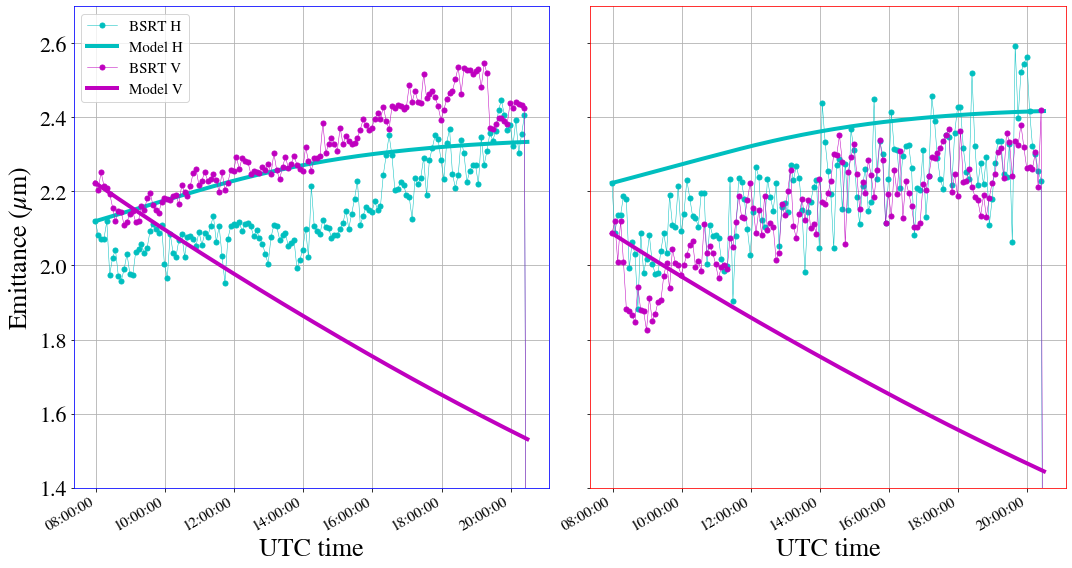

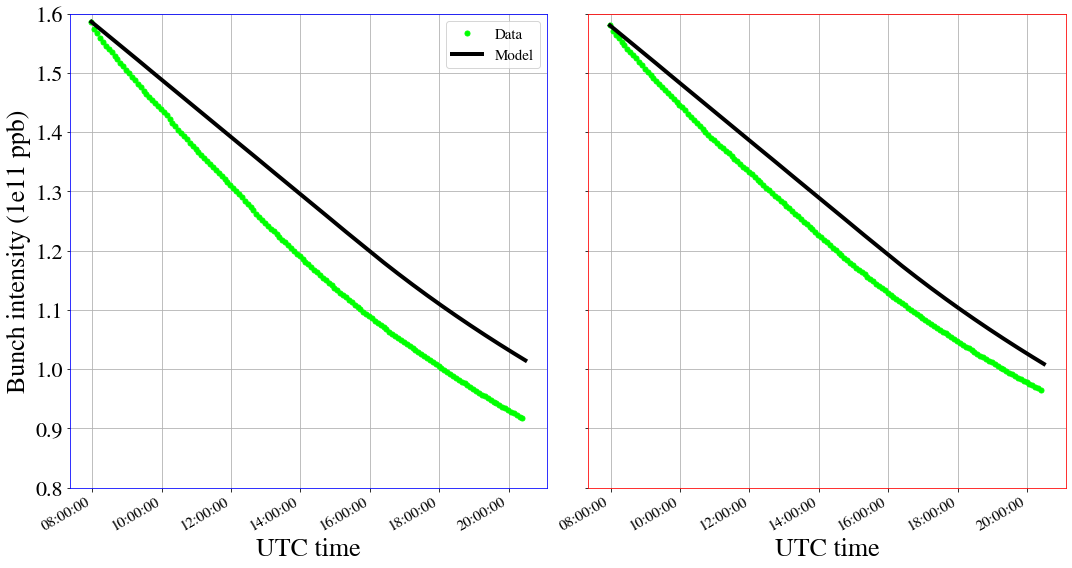

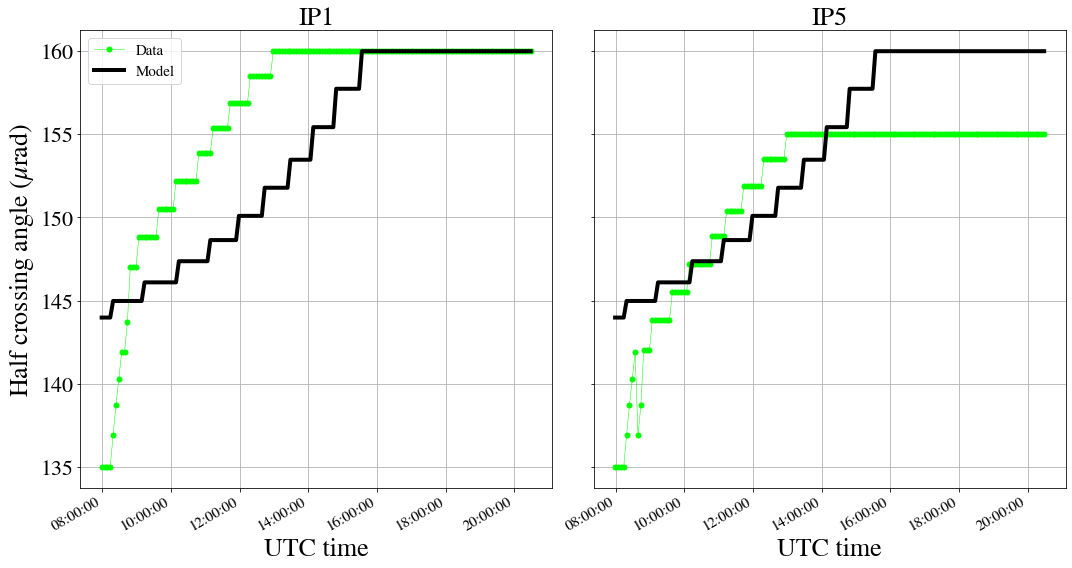

In [20]:
# %% 

# Plot emittances, also works with BBB
fig, ax = plt.subplots(figsize=(15,8), ncols=2, sharex=True, sharey=True)
plt.sca(ax[0])
plt.xlabel("UTC time")
plt.grid()
plt.ylabel(r"Emittance ($\mu$m)")
plt.plot(myLumiModel.df_init_b1[f"eh_interp_{bunch_family}"].apply(lambda x:np.mean(x)), c='c', lw=0.5, marker='o', linestyle='-', ms=5, label='BSRT H')
plt.plot(results["time"], results["emitx_B1"].apply(lambda x:np.mean(x))*1e6, c='c', linestyle='-', label="Model H")

plt.plot(myLumiModel.df_init_b1[f"ev_interp_{bunch_family}"].apply(lambda x:np.mean(x)), c='m', lw=0.5, marker='o', linestyle='-', ms=5, label='BSRT V')
plt.plot(results["time"], results["emity_B1"].apply(lambda x:np.mean(x))*1e6, c='m', linestyle='-', label='Model V')
plt.legend()

plt.sca(ax[1])
plt.xlabel("UTC time")
plt.grid()
plt.plot(myLumiModel.df_init_b2[f"eh_interp_{bunch_family}"].apply(lambda x:np.mean(x)), c='c', lw=0.5, marker='o', linestyle='-', ms=5)
plt.plot(results["time"], results["emitx_B2"].apply(lambda x:np.mean(x))*1e6, c='c', linestyle='-')

plt.plot(myLumiModel.df_init_b2[f"ev_interp_{bunch_family}"].apply(lambda x:np.mean(x)), c='m', lw=0.5, marker='o', linestyle='-', ms=5)
plt.plot(results["time"], results["emity_B2"].apply(lambda x:np.mean(x))*1e6, c='m', linestyle='-')

if bunch_family=="coll":
    plt.ylim(1.4, 2.7)
else:
    plt.ylim(1.4, 3.7)

date_format = mdates.DateFormatter('%H:%M:%S')
ax[0].xaxis_date()
ax[0].xaxis.set_major_formatter(date_format)
ax[1].xaxis.set_major_formatter(date_format)

for vv in ["bottom", "left", "right", "top"]:
    ax[0].spines[vv].set_color('blue') # set bottom spine color to blue
    ax[1].spines[vv].set_color('r') # set left spine color to blue

fig.autofmt_xdate()
fig.tight_layout()

#%%
# Plot bunch intensity
fig, ax = plt.subplots(figsize=(15,8), ncols=2, sharex=True, sharey=True)
plt.sca(ax[0])
plt.xlabel("UTC time")
plt.grid()
plt.ylabel("Bunch intensity (1e11 ppb)")
plt.plot(myLumiModel.df_init_b1[f"b_inten_interp_{bunch_family}"].apply(lambda x:np.mean(x))/1e11, c='lime', lw=0.5, marker='o', linestyle='', ms=5, label='Data')
plt.plot(results["time"], results["inten_B1"].apply(lambda x:np.mean(x))/1e11, c='k', linestyle='-', label="Model")
plt.legend()

plt.sca(ax[1])
plt.xlabel("UTC time")
plt.grid()
plt.plot(myLumiModel.df_init_b2[f"b_inten_interp_{bunch_family}"].apply(lambda x:np.mean(x))/1e11, c='lime', lw=0.5, marker='o', linestyle='', ms=5)
plt.plot(results["time"], results["inten_B2"].apply(lambda x:np.mean(x))/1e11, c='k', linestyle='-')

plt.ylim(0.8, 1.6)

for vv in ["bottom", "left", "right", "top"]:
    ax[0].spines[vv].set_color('blue') # set bottom spine color to blue
    ax[1].spines[vv].set_color('r') # set left spine color to blue

date_format = mdates.DateFormatter('%H:%M:%S')
ax[0].xaxis_date()
ax[0].xaxis.set_major_formatter(date_format)
ax[1].xaxis.set_major_formatter(date_format)

fig.autofmt_xdate()
fig.tight_layout()




# %%
# Plot bunch length

fig, ax = plt.subplots(figsize=(15,8), ncols=2, sharex=True, sharey=True)
plt.sca(ax[0])
plt.xlabel("UTC time")
plt.grid()
plt.ylabel("Bunch length (ns)")
plt.plot(myLumiModel.df_init_b1[f"bl_interp_m_{bunch_family}"].apply(lambda x:np.mean(x))*4.0/clight*1e9, c='lime', lw=0.5, marker='o', linestyle='-', ms=5, label='Data')
plt.plot(results["time"], results["bl_s_B1"].apply(lambda x:np.mean(x))*1e9, c='k', linestyle='-', label="Model")
plt.legend()

plt.sca(ax[1])
plt.xlabel("UTC time")
plt.grid()
plt.plot(myLumiModel.df_init_b2[f"bl_interp_m_{bunch_family}"].apply(lambda x:np.mean(x))*4.0/clight*1e9, c='lime', lw=0.5, marker='o', linestyle='-', ms=5)
plt.plot(results["time"], results["bl_s_B2"].apply(lambda x:np.mean(x))*1e9, c='k', linestyle='-')

plt.ylim(1.14, 1.3)

for vv in ["bottom", "left", "right", "top"]:
    ax[0].spines[vv].set_color('blue') # set bottom spine color to blue
    ax[1].spines[vv].set_color('r') # set left spine color to blue

date_format = mdates.DateFormatter('%H:%M:%S')
ax[0].xaxis_date()
ax[0].xaxis.set_major_formatter(date_format)
ax[1].xaxis.set_major_formatter(date_format)

fig.autofmt_xdate()
fig.tight_layout()

# %%

# Plot xing angle

fig, ax = plt.subplots(figsize=(15,8), ncols=2, sharex=True, sharey=True)
plt.sca(ax[0])
plt.xlabel("UTC time")
plt.grid()
plt.ylabel(r"Half crossing angle ($\mu$rad)")
plt.plot(abs(myLumiModel.df_init_b1["xing_angle_IP1"])/2.*1e6, c='lime', lw=0.5, marker='o', linestyle='-', ms=5, label='Data')
plt.plot(results["time"], abs(results["xing"])/2.*1e6, c='k', linestyle='-', label="Model")
plt.legend()
plt.title("IP1")

plt.sca(ax[1])
plt.xlabel("UTC time")
plt.grid()
plt.plot(abs(myLumiModel.df_init_b2["xing_angle_IP5"])/2.*1e6, c='lime', lw=0.5, marker='o', linestyle='-', ms=5)
plt.plot(results["time"], abs(results["xing"])/2.*1e6 , c='k', linestyle='-')
plt.title("IP5")

date_format = mdates.DateFormatter('%H:%M:%S')
ax[0].xaxis_date()
ax[0].xaxis.set_major_formatter(date_format)
ax[1].xaxis.set_major_formatter(date_format)

fig.autofmt_xdate()
fig.tight_layout()

# %%

# Plot beta*

fig, ax = plt.subplots(figsize=(9,6))

plt.xlabel("UTC time")
plt.grid()
plt.ylabel(r"$\beta^*$ (cm)")
plt.plot(myLumiModel.df_init_b1["betastar_IP1"], c='lime', lw=0.5, marker='o', linestyle='-', ms=5, label='Data')
plt.plot(results["time"], results["beta"]*1e2, c='k', linestyle='-', label="Model")
plt.title
plt.legend()

date_format = mdates.DateFormatter('%H:%M:%S')
ax.xaxis_date()
ax.xaxis.set_major_formatter(date_format)

fig.autofmt_xdate()
fig.tight_layout()

# %%
if bunch_family=="coll":
    # Plot lumi of ATLAS, CMS and avg

    fig, ax = plt.subplots(figsize=(9,6))
    plt.xlabel("UTC time")
    plt.grid()
    plt.ylabel(r"Luminosity (Hz/$cm^2$)")


    lumi_atlas = df["ATLAS:BUNCH_LUMI_INST"].apply(lambda x:1e-4*np.sum(x[myLumiModel.idx_b1]))
    lumi_cms = df["CMS:BUNCH_LUMI_INST"].apply(lambda x:1e-4*np.sum(x[myLumiModel.idx_b1])) 
    #plt.plot([pd.Timestamp(i) for i in lumi_atlas.index], lumi_atlas, c='lime', lw=0.5, marker='o', linestyle='-', ms=5, label='Data')
    #plt.plot([pd.Timestamp(i) for i in lumi_cms.index], lumi_cms, c='lime', lw=0.5, marker='o', linestyle='-', ms=5, label='Data')
    plt.plot([pd.Timestamp(i) for i in lumi_cms.index], 0.5*(lumi_cms + lumi_atlas), c='lime', lw=0.5, marker='o', linestyle='-', ms=5, label='Data')
    #plt.plot(results["time"], results["lumi_CMS"]/1e38, c='r', linestyle='--')
    #plt.plot(results["time"], results["lumi_ATLAS"]/1e38, c='b', linestyle='--')
    plt.plot(results["time"], 0.5*(results["lumi_ATLAS"]/1e38 + results["lumi_CMS"]/1e38), c='k', linestyle='-')
    plt.ylim(1.2, 2.4)

    date_format = mdates.DateFormatter('%H:%M:%S')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(date_format)

    fig.autofmt_xdate()
    fig.tight_layout()

    
# %%

# Plot pileup from the model
if bunch_family=="coll":
    fig, ax = plt.subplots(figsize=(9,6))
    plt.xlabel("UTC time")
    plt.grid()
    plt.ylabel("Pile-up")
    plt.plot(results["time"], results["pu_avg"], c='k', linestyle='-', label="Model average")
    plt.plot(results["time"], results["pu_ATLAS"].apply(lambda x:np.mean(x)), c='b', linestyle='-', label="Model ATLAS", lw=1)
    plt.plot(results["time"], results["pu_CMS"].apply(lambda x:np.mean(x)), c='r', linestyle='-', label="Model CMS", lw=1)
    #plt.axhline(y=myLumiModel.max_pileup, color='k', linestyle='--', label="Level pile-up")
    plt.legend()

    # Define the tolerance
    tolerance = myLumiModel.lumi_tol_percentage/100.0

    # Calculate the max pileup and the upper and lower bounds
    max_pileup = myLumiModel.max_pileup
    lower_bound = max_pileup - (max_pileup * tolerance)
    upper_bound = max_pileup + (max_pileup * tolerance)

    # Create a horizontal bar
    plt.axhspan(lower_bound, upper_bound, alpha=0.2, color='gray')

    date_format = mdates.DateFormatter('%H:%M:%S')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(date_format)

    fig.autofmt_xdate()
    fig.tight_layout()
# %%




# Create fake data

In [31]:
#%%
# create fake inteprolated dataframe
myLumiModel = LumiModel()

myLumiModel.compute_filling_scheme = False
myLumiModel.idx_b1 = [0]
myLumiModel.idx_b2 = [0]
myLumiModel.idx_noncoll_B1 = []
myLumiModel.idx_noncoll_B2 = []

myLumiModel.level_bl = 1.0e-9
myLumiModel.level_lumi = 2.2e38
myLumiModel.max_pileup = 65

myLumiModel.ex_extra = 0.01
myLumiModel.ey_extra = 0.08

myLumiModel.lumi_tol_percentage = 1.

myLumiModel.sigmaBOff_m2 = 80e-31

myLumiModel.xing_ref = 160.
myLumiModel.flag_xing_ct = False
myLumiModel.optics()

myLumiModel.number_of_bunches = 2380

time_range = pd.date_range(start=pd.Timestamp("2023-07-16 07:58:54.061613525"), periods=240, freq='5T')

# Create a DataFrame with the generated timestamps as the index
df_fake = pd.DataFrame(index=time_range)
df_fake['LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_V'] = [np.array([1.8]) for i in range(len(df_fake))]
df_fake['LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_H'] = [np.array([1.8]) for i in range(len(df_fake))]
df_fake['LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_V'] = [np.array([1.8]) for i in range(len(df_fake))]
df_fake['LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_H'] = [np.array([1.8]) for i in range(len(df_fake))]
df_fake['LHC.BQM.B1:BUNCH_LENGTH_MEAN'] = 1.2e-9
df_fake['LHC.BQM.B2:BUNCH_LENGTH_MEAN'] = 1.2e-9
df_fake['LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY'] = [np.array([1.8e11]) for i in range(len(df_fake))]
df_fake['LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY'] = [np.array([1.8e11]) for i in range(len(df_fake))]
df_fake["LHC.RUNCONFIG:IP1-XING-V-MURAD"] = 135.
df_fake["LHC.RUNCONFIG:IP5-XING-H-MURAD"] = 135.
df_fake["HX:BETASTAR_IP1"] = 120.
df_fake["HX:BETASTAR_IP5"] = 120.

myLumiModel.initialize(df_fake, bbb_or_avg="avg")

case1: uncorrected BSRT
HB1  VB1  HB2  VB2
1.0 1.0 1.0 1.0


Filling scheme computation de-activated. Considering all bunches colliding.
Number of bunches 2380
Colliding bunches in B1 and B2: 1 1
Non colliding bunches in B1 and B2: 0 0

Leveling lumi at 2.1745985625e+38 instead of 2.2e+38 due to max pileup set at 65
Leveled lumi from 2.152852576875e+38 to 2.196344548125e+38

Time step 5.0 min
Initial conditions: 
 For B1: 
 ev_interp_coll                       [1.8]
eh_interp_coll                       [1.8]
bl_interp_m_coll            [0.0899377374]
b_inten_interp_coll       [180000000000.0]
ev_interp_noncoll                    [nan]
eh_interp_noncoll                    [nan]
bl_interp_m_noncoll                  [nan]
b_inten_interp_noncoll               [nan]
xing_angle_IP1                     0.00027
xing_angle_IP5                     0.00027
betastar_IP1                         120.0
betastar_IP5                         120.0
beam                                    B1
Name: 2023-07

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432

In [32]:
df_fake

LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_V  \
2023-07-16 07:58:54.061613525                             [1.8]   
2023-07-16 08:03:54.061613525                             [1.8]   
2023-07-16 08:08:54.061613525                             [1.8]   
2023-07-16 08:13:54.061613525                             [1.8]   
2023-07-16 08:18:54.061613525                             [1.8]   
...                                                         ...   
2023-07-17 03:33:54.061613525                             [1.8]   
2023-07-17 03:38:54.061613525                             [1.8]   
2023-07-17 03:43:54.061613525                             [1.8]   
2023-07-17 03:48:54.061613525                             [1.8]   
2023-07-17 03:53:54.061613525                             [1.8]   

                              LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_H  \
2023-07-16 07:58:54.061613525                             [1.8]   
2023-07-16 08:03:54.061613525                             [1.8]   
2023-07-16 08:08:54.061613525                             [1.8]   
2023-07-16 08:13:54.061613525                             [1.8]   
2023-07-16 08:18:54.061613525                             [1.8]   
...                                                         ...   
2023-07-17 03:33:54.061613525                             [1.8]   
2023-07-17 03:38:54.061613525                             [1.8]   
2023-07-17 03:43:54.061613525                             [1.8]   
2023-07-17 03:48:54.061613525                             [1.8]   
2023-07-17 03:53:54.061613525                             [1.8]   

                              LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_V  \
2023-07-16 07:58:54.061613525                             [1.8]   
2023-07-16 08:03:54.061613525                             [1.8]   
2023-07-16 08:08:54.061613525                             [1.8]   
2023-07-16 08:13:54.061613525                             [1.8]   
2023-07-16 08:18:54.061613525                             [1.8]   
...                                                         ...   
2023-07-17 03:33:54.061613525                             [1.8]   
2023-07-17 03:38:54.061613525                             [1.8]   
2023-07-17 03:43:54.061613525                             [1.8]   
2023-07-17 03:48:54.061613525                             [1.8]   
2023-07-17 03:53:54.061613525                             [1.8]   

                              LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_H  \
2023-07-16 07:58:54.061613525                             [1.8]   
2023-07-16 08:03:54.061613525                             [1.8]   
2023-07-16 08:08:54.061613525                             [1.8]   
2023-07-16 08:13:54.061613525                             [1.8]   
2023-07-16 08:18:54.061613525                             [1.8]   
...                                                         ...   
2023-07-17 03:33:54.061613525                             [1.8]   
2023-07-17 03:38:54.061613525                             [1.8]   
2023-07-17 03:43:54.061613525                             [1.8]   
2023-07-17 03:48:54.061613525                             [1.8]   
2023-07-17 03:53:54.061613525                             [1.8]   

                               LHC.BQM.B1:BUNCH_LENGTH_MEAN  \
2023-07-16 07:58:54.061613525                  1.200000e-09   
2023-07-16 08:03:54.061613525                  1.200000e-09   
2023-07-16 08:08:54.061613525                  1.200000e-09   
2023-07-16 08:13:54.061613525                  1.200000e-09   
2023-07-16 08:18:54.061613525                  1.200000e-09   
...                                                     ...   
2023-07-17 03:33:54.061613525                  1.200000e-09   
2023-07-17 03:38:54.061613525                  1.200000e-09   
2023-07-17 03:43:54.061613525                  1.200000e-09   
2023-07-17 03:48:54.061613525                  1.200000e-09   
2023-07-17 03:53:54.061613525                  1.200000e-09   

                               LHC.BQM.B2:BUNCH_LENGT

In [33]:
fromData_xingbeta    = False
fromData_emit        = False
fromData_intensity   = False
fromData_bl          = False
if not fromData_emit:
    # By default, IBS and elastic scattering are included
    include_coupling = False
    include_boffBU   = False
    include_extraBU  = True

verbose = False
myLumiModel.verbose = verbose

flag_change_lookup_at_30cm = True
#level_on = 'avg' # 'avg' or 'CMS' or 'ATLAS'
level_on = 'avg' # 'avg' or 'CMS' or 'ATLAS'
bunch_family = "coll" # 'coll' or 'noncoll'

assert fromData_bl or not fromData_emit, "If fromData_bl is False, fromData_emit must also be False."

assert (len(myLumiModel.idx_b1) > 0) or (bunch_family != "coll"), "If bunch_family is 'coll', idx_b1 must not be empty"
assert (len(myLumiModel.idx_noncoll_B1) > 0) or (bunch_family != "noncoll"), "If bunch_family is 'noncoll', idx_noncoll_b1 must not be empty"

In [34]:
for current_time_step in range(0, myLumiModel.steps):

    myLumiModel.current_time = current_time_step

    if myLumiModel.current_time == 0:
        myLumiModel.current_beta = myLumiModel.df_init_b1["betastar_IP1"].iloc[current_time_step]*1e-2
        myLumiModel.current_xing = myLumiModel.df_init_b1["xing_angle_IP1"].iloc[current_time_step]
        myLumiModel.beta_idx = 0
        myLumiModel.current_time = current_time_step
        myLumiModel.current_emitx_B1 = myLumiModel.df_init_b1[f"eh_interp_{bunch_family}"].iloc[current_time_step]*1e-6
        myLumiModel.current_emity_B1 = myLumiModel.df_init_b1[f"ev_interp_{bunch_family}"].iloc[current_time_step]*1e-6
        myLumiModel.current_emitx_B2 = myLumiModel.df_init_b2[f"eh_interp_{bunch_family}"].iloc[current_time_step]*1e-6
        myLumiModel.current_emity_B2 = myLumiModel.df_init_b2[f"ev_interp_{bunch_family}"].iloc[current_time_step]*1e-6
        myLumiModel.current_bl_s_B1 = myLumiModel.df_init_b1[f"bl_interp_m_{bunch_family}"].iloc[current_time_step]*4.0/clight
        myLumiModel.current_bl_s_B2 = myLumiModel.df_init_b2[f"bl_interp_m_{bunch_family}"].iloc[current_time_step]*4.0/clight
        myLumiModel.current_inten_B1 = myLumiModel.df_init_b1[f"b_inten_interp_{bunch_family}"].iloc[current_time_step]
        myLumiModel.current_inten_B2 = myLumiModel.df_init_b2[f"b_inten_interp_{bunch_family}"].iloc[current_time_step]

        if bunch_family=="coll":
            Lumi_init_CMS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2,
                                                myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                myLumiModel.current_beta, myLumiModel.current_xing, "CMS")
            Lumi_init_ATLAS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2, 
                                                    myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                    myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                    myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                    myLumiModel.current_beta, myLumiModel.current_xing, "ATLAS")


            myLumiModel.current_lumi_ATLAS = Lumi_init_ATLAS
            myLumiModel.current_lumi_CMS = Lumi_init_CMS
            myLumiModel.current_pu_ATLAS = myLumiModel.cmp_pileup(Lumi_init_ATLAS)
            myLumiModel.current_pu_CMS = myLumiModel.cmp_pileup(Lumi_init_CMS)
        #myLumiModel.save_data()
        #continue

    else:

        # Emittance

        if fromData_emit:
            if myLumiModel.verbose:
                print("Using emittances from data")
            myLumiModel.current_emitx_B1 = myLumiModel.df_init_b1["eh_interp_coll"].iloc[current_time_step]*1e-6
            myLumiModel.current_emity_B1 = myLumiModel.df_init_b1["ev_interp_coll"].iloc[current_time_step]*1e-6
            myLumiModel.current_emitx_B2 = myLumiModel.df_init_b2["eh_interp_coll"].iloc[current_time_step]*1e-6
            myLumiModel.current_emity_B2 = myLumiModel.df_init_b2["ev_interp_coll"].iloc[current_time_step]*1e-6       
        
        else:
            if myLumiModel.verbose:
                print("Using emittances from previous step and applying IBS model")
            myLumiModel.IBS_model()
            myLumiModel.SR_model()
            myLumiModel.Elastic_scattering_model()
            if include_coupling:
                myLumiModel.Coupling_model()
            if include_extraBU:
                myLumiModel.ExtraBU_model()
            if include_boffBU and bunch_family=="coll":
                myLumiModel.Boff_BU_model()
            
            myLumiModel.current_emitx_B1 = myLumiModel.current_emitx_B1_IBS + myLumiModel.dexdt1 * myLumiModel.dt_step - myLumiModel.dexy1 * myLumiModel.Cfactor  + myLumiModel.dex_noise_B1 + myLumiModel.dex_Boff_B1
            myLumiModel.current_emity_B1 = myLumiModel.current_emity_B1_IBS_SR + myLumiModel.dexdt1 * myLumiModel.dt_step + myLumiModel.dexy1 * myLumiModel.Cfactor + myLumiModel.dey_noise_B1 + myLumiModel.dey_Boff_B1
            myLumiModel.current_emitx_B2 = myLumiModel.current_emitx_B2_IBS + myLumiModel.dexdt2 * myLumiModel.dt_step - myLumiModel.dexy2 * myLumiModel.Cfactor + myLumiModel.dex_noise_B2 + myLumiModel.dex_Boff_B2
            myLumiModel.current_emity_B2 = myLumiModel.current_emity_B2_IBS_SR + myLumiModel.dexdt2 * myLumiModel.dt_step + myLumiModel.dexy2 * myLumiModel.Cfactor  + myLumiModel.dey_noise_B2 + myLumiModel.dey_Boff_B2

        # Intensity

        if fromData_intensity or bunch_family=="noncoll":
            if myLumiModel.verbose:
                print("Using intensities from data")
            myLumiModel.current_inten_B1 = myLumiModel.df_init_b1[f"b_inten_interp_{bunch_family}"].iloc[current_time_step]
            myLumiModel.current_inten_B2 = myLumiModel.df_init_b2[f"b_inten_interp_{bunch_family}"].iloc[current_time_step]
        else:
            if myLumiModel.verbose:
                print("Using intensities from previous step and applying burn-off")
            myLumiModel.Boff_losses_model()
        
        # Bunch length

        if fromData_bl:
            if myLumiModel.verbose:
                print("Using bunch length from data")
            myLumiModel.current_bl_s_B1 = myLumiModel.df_init_b1["bl_interp_m_coll"].iloc[current_time_step]*4.0/clight
            myLumiModel.current_bl_s_B2 = myLumiModel.df_init_b2["bl_interp_m_coll"].iloc[current_time_step]*4.0/clight
        
        else:
            if myLumiModel.verbose:
                print("Using bunch length from previous step and applying IBS model")

            myLumiModel.current_bl_s_B1 = myLumiModel.current_bl_s_B1_IBS 
            myLumiModel.current_bl_s_B2 = myLumiModel.current_bl_s_B2_IBS

            if np.mean(myLumiModel.current_bl_s_B1_IBS) < myLumiModel.level_bl:
                myLumiModel.current_bl_s_B1 = np.array([myLumiModel.level_bl]*len(myLumiModel.current_bl_s_B1_IBS))
            if np.mean(myLumiModel.current_bl_s_B2_IBS) < myLumiModel.level_bl:
                myLumiModel.current_bl_s_B2 = np.array([myLumiModel.level_bl]*len(myLumiModel.current_bl_s_B2_IBS))
        
        # Crossing angle and beta*

    if fromData_xingbeta or bunch_family=="noncoll":
        if myLumiModel.verbose:
            print("Using beta* and crossing angle from data")
        myLumiModel.current_beta = myLumiModel.df_init_b1["betastar_IP1"].iloc[current_time_step]*1e-2
        myLumiModel.current_xing = myLumiModel.df_init_b1["xing_angle_IP1"].iloc[current_time_step]
        myLumiModel.beta_idx = None
    
    else:
        if myLumiModel.verbose:
            print("Using beta* and crossing angle from previous step and leveling lumi")


        myLumiModel.current_lumi_ATLAS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2,
                                                myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                myLumiModel.current_beta, myLumiModel.current_xing, "CMS")
        myLumiModel.current_lumi_CMS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2, 
                                                    myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                    myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                    myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                    myLumiModel.current_beta, myLumiModel.current_xing, "ATLAS")
        
        if level_on == 'avg':
            current_lumi = 0.5*(np.mean(myLumiModel.current_lumi_ATLAS) + np.mean(myLumiModel.current_lumi_CMS))
            
        elif level_on == "ATLAS":
            current_lumi = np.mean(myLumiModel.current_lumi_ATLAS)
        
        elif level_on == 'CMS':
            current_lumi = np.mean(myLumiModel.current_lumi_CMS)
            
        if (current_lumi<myLumiModel.level_lumi - myLumiModel.lumi_tol_percentage/100.0*myLumiModel.level_lumi) :
                
                allbeta_Lumi_init_CMS = [np.mean(myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2,
                                                                    myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                                    myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                                    myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                                    current_beta, current_xing*2.0*1e-6, "CMS")) for current_beta, current_xing in zip(myLumiModel.df_optics.beta.values, myLumiModel.df_optics.xing.values)]
                allbeta_Lumi_init_ATLAS = [np.mean(myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2,
                                                                            myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                                            myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                                            myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                                            current_beta, current_xing*2.0*1e-6, "ATLAS")) for current_beta, current_xing in zip(myLumiModel.df_optics.beta.values, myLumiModel.df_optics.xing.values)]   
                
                if level_on == 'avg':
                    allbeta_Lumi_init = 0.5*(np.array(allbeta_Lumi_init_ATLAS) + np.array(allbeta_Lumi_init_CMS))    
                elif level_on == 'ATLAS':
                    allbeta_Lumi_init = np.array(allbeta_Lumi_init_ATLAS) 
                elif level_on == 'CMS':
                    allbeta_Lumi_init = np.array(allbeta_Lumi_init_CMS)

                beta_idx = np.nanargmin(abs(allbeta_Lumi_init-myLumiModel.level_lumi))

                if allbeta_Lumi_init[beta_idx]>myLumiModel.level_lumi + myLumiModel.lumi_tol_percentage/100.0*myLumiModel.level_lumi:
                    # go back one beta* step
                    beta_idx = beta_idx - 1
                #elif (allbeta_Lumi_init[beta_idx]<myLumiModel.level_lumi - myLumiModel.lumi_tol_percentage/100.0*myLumiModel.#level_lumi) and (beta_idx<len(allbeta_Lumi_init)-1):
                #    # go forward one beta* step
                #    beta_idx = beta_idx + 1
                
                myLumiModel.current_beta = myLumiModel.df_optics.beta.values[beta_idx]
                myLumiModel.current_xing = myLumiModel.df_optics.xing.values[beta_idx]*2.0*1e-6
                myLumiModel.beta_idx = beta_idx

                myLumiModel.current_lumi_CMS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2,
                                                    myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                    myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                    myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                    myLumiModel.current_beta, myLumiModel.current_xing, "CMS")
                myLumiModel.current_lumi_ATLAS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2, 
                                                        myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                        myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                        myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                        myLumiModel.current_beta, myLumiModel.current_xing, "ATLAS")
                myLumiModel.current_pu_ATLAS = myLumiModel.cmp_pileup(myLumiModel.current_lumi_ATLAS)
                myLumiModel.current_pu_CMS = myLumiModel.cmp_pileup(myLumiModel.current_lumi_CMS)

                if verbose:
                    print(f"Time step {current_time_step}: Average lumi between the two experiments is lower than level lumi {myLumiModel.level_lumi}. Going to matching point: beta* = ", myLumiModel.df_optics.beta.values[beta_idx], "m and xing = ", myLumiModel.df_optics.xing.values[beta_idx], "um which results in lumi ", allbeta_Lumi_init[beta_idx], "Hz/m2")


    # Luminosity and pile-up

    if bunch_family=="coll":
        Lumi_CMS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2,
                                            myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                            myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                            myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                            myLumiModel.current_beta, myLumiModel.current_xing, "CMS")
        Lumi_ATLAS = myLumiModel.Lumi_inst(myLumiModel.current_inten_B1, myLumiModel.current_inten_B2, 
                                                myLumiModel.current_emitx_B1, myLumiModel.current_emity_B1,
                                                myLumiModel.current_emitx_B2, myLumiModel.current_emity_B2,
                                                myLumiModel.current_bl_s_B1, myLumiModel.current_bl_s_B2,
                                                myLumiModel.current_beta, myLumiModel.current_xing, "ATLAS")


        myLumiModel.current_lumi_ATLAS = Lumi_ATLAS
        myLumiModel.current_lumi_CMS = Lumi_CMS
        myLumiModel.current_pu_ATLAS = myLumiModel.cmp_pileup(Lumi_ATLAS)
        myLumiModel.current_pu_CMS = myLumiModel.cmp_pileup(Lumi_CMS)  

    if (myLumiModel.current_beta  == 0.3) and (flag_change_lookup_at_30cm):
        myLumiModel.current_lookup_table = myLumiModel.lookup_table[0.3]

    myLumiModel.save_data()

results = myLumiModel.dump_to_df()
print("Finished!")

Finished!


In [53]:
from scipy.integrate import cumtrapz

op_days    = 130
efficiency = 0.5
tau0       = 4.5

results["rel_time"] = (results["time"] - results["time"].iloc[0]).dt.total_seconds()
lumi_int_pb = cumtrapz(results['lumi_avg'].values, x=results['rel_time'].values)*1e-40
lumi_int_pb = np.insert(lumi_int_pb, 0, 0)
results['lumi_int_pb_fill'] = lumi_int_pb

lumi_int_m_fill_taround = lumi_int_pb*1e40/(np.array(results['rel_time'].values) + tau0*3600.0)#*24*3600.0
lumi_int_m_day_taround = lumi_int_pb*1e40/(np.array(results['rel_time']) + tau0*3600.0)*24*3600.0
results["lumi_int_m_fill_taround"] = lumi_int_m_fill_taround

idx = np.argmax(results["lumi_int_pb_fill"].values*1e40/(results["rel_time"].values + tau0*3600))
opt_fill_length = results["rel_time"].iloc[idx]/3600.0
print('Optimal fill length: %sh'%(opt_fill_length))
results['topt'] = opt_fill_length/3600.0

myint = results["lumi_int_pb_fill"]*1e40/(results["rel_time"].values + tau0*3600)
opt_int_lumi = results['lumi_int_pb_fill'][idx]

print('Opt int lumi [pb^-1]: %s'%opt_int_lumi)
print('Yearly performance: %s fb-1/day, %s fb-1/year'%((lumi_int_m_day_taround[idx]*1e-43), (lumi_int_m_day_taround[idx]*1e-43)*op_days*efficiency))

lumi_avg_xing = 1.0/(opt_int_lumi*1e40) * cumtrapz(np.array(results['lumi_avg'][0:idx])*np.array(results['xing'][0:idx])*2.0*1e-6, x=results['time'][0:idx])

results['lumi_year'] = (lumi_int_m_day_taround[idx]*1e-43)*op_days*efficiency
results['lumi_day']  = (lumi_int_m_day_taround[idx]*1e-43)
results['Llevel0'] = myLumiModel.level_lumi

level_time = results[np.isclose(results['lumi_avg'], myLumiModel.level_lumi, rtol=1e-2)].iloc[-1]['rel_time']/3600.0

Optimal fill length: 14.833333333333334h
Opt int lumi [pb^-1]: 1100.3911776530276
Yearly performance: 1.3660028412244485 fb-1/day, 88.79018467958915 fb-1/year


Text(0.5, 0, 'Time in SB (h)')

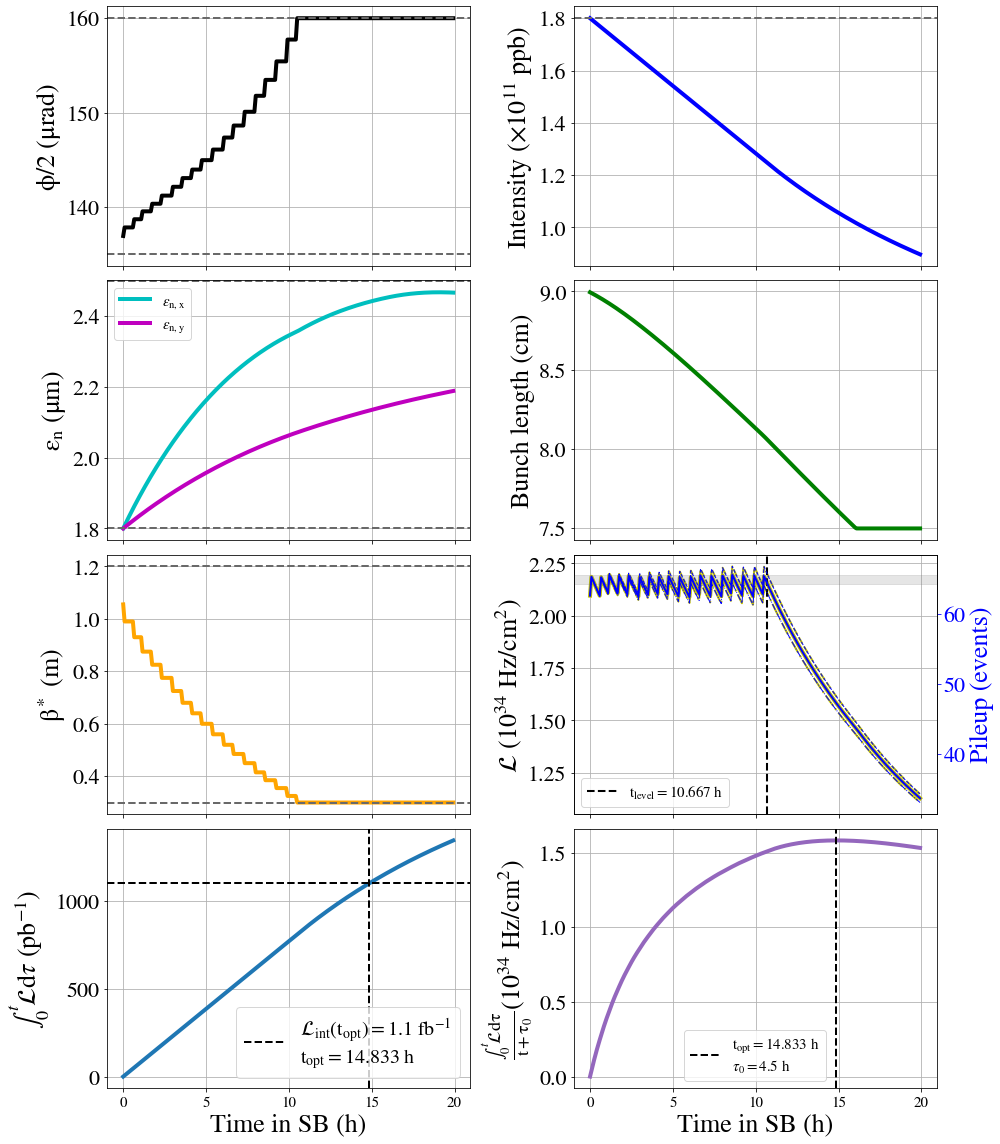

In [57]:


# %%
fig,ax = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(14,16))
plt.sca(ax[0,0])
plt.grid()
#opt_fill_length  = results['topt'].iloc[0]
#level_time       = results['tlevel'].iloc[0]
#results_test  = results[results['beta']==0.3]
#level_time = results_test[results_test['lumi'] == results_test['lumi'].max()]['time'].values[0]/3600.0

int_hline        = results[np.isclose(results['rel_time'],opt_fill_length*3600.0)]['lumi_int_pb_fill'].values[0]#results[results['time'] == opt_fill_length*3600.0]['lumi_int_pb_fill'].values[0]

plt.plot(results['rel_time']/3600.0, results['xing']*1e6/2., c='k',  marker='o', ms=0)
plt.ylabel(r'$\rm \phi/2 \ (\mu rad)$')
plt.axhline(135., linestyle='--', c='dimgray', lw=2)
plt.axhline(160.,linestyle='--', c='dimgray', lw=2)

plt.sca(ax[0,1])
plt.grid()

plt.plot(results['rel_time']/3600.0, results['inten_B1']/1e11, c='b',  marker='o', ms=0)
plt.ylabel(r'Intensity $\rm (\times 10^{11} \ ppb)$')
plt.axhline(1.8,linestyle='--', c='dimgray', lw=2)
#plt.axhline(1.18771,linestyle='--', c='dimgray', lw=2)


plt.sca(ax[1,0])
plt.grid()

plt.plot(results['rel_time']/3600.0, results['emitx_B1'].apply(lambda x:np.mean(x))*1e6, c='c',  marker='o', ms=0, label=r'$\epsilon_{\rm n,x}$')
plt.plot(results['rel_time']/3600.0, results['emity_B1'].apply(lambda x:np.mean(x))*1e6, c='m',  marker='o', ms=0, label=r'$\epsilon_{\rm n,y}$')
#plt.plot(results['time']/3600.0, results['emit_avg'], c='r',  marker='o', ms=0, label=r'$\epsilon_{\rm n,conv}$')
plt.ylabel(r'$\rm \epsilon_n \ (\mu m)$')
plt.axhline(1.8, linestyle='--', c='dimgray', lw=2)
plt.axhline(2.5,linestyle='--', c='dimgray', lw=2)
plt.legend(fontsize=15)


plt.sca(ax[1,1])
plt.ylabel(r'Bunch length (cm)')
plt.grid()
plt.plot(results['rel_time']/3600.0, results['bl_s_B1'].apply(lambda x:np.mean(x))*clight/4.*1e2, c='g',  marker='o', ms=0)

#plt.axhline(7.5, linestyle='--', c='dimgray', lw=2)
#plt.axhline(9.,linestyle='--', c='dimgray', lw=2)


plt.sca(ax[2,0])
plt.ylabel(r'$\rm \beta^*$ (m)')
plt.grid()
plt.plot(results['rel_time']/3600.0, results['beta'], c='orange',  marker='o', ms=0)

plt.axhline(1.2, linestyle='--', c='dimgray', lw=2)
plt.axhline(0.3,linestyle='--', c='dimgray', lw=2)
#plt.xlabel('Time (h)')

plt.sca(ax[2,1])
plt.ylabel('$\mathcal{L}$ ' + r'$\rm (10^{34} \ Hz/cm^{2})$')
#plt.ylabel(r'($\mathcal(L) \rm 10^{34} Hz/cm^{2})$')
plt.grid()
plt.plot(results['rel_time']/3600.0, np.array(results['lumi_avg'])/1e38, c='y',  marker='o', ms=0)
plt.plot(results['rel_time']/3600.0, np.array(results['lumi_ATLAS'].apply(lambda x:np.mean(x)))/1e38, c='y',  marker='o', ms=0, linestyle='-.', lw=2)
plt.plot(results['rel_time']/3600.0, np.array(results['lumi_CMS'].apply(lambda x:np.mean(x)))/1e38, c='y',  marker='o', ms=0, linestyle='--', lw=2)


#level_time = results[np.isclose(results['lumi'], 2.2e38, rtol=1e-2)].iloc[0]['time']/3600.0
#plt.axvline(level_time, c='k', linestyle='--', lw=2, label=r'$\rm t_{level} = %s \ h$' %round(level_time, 3))
plt.axvline(level_time, c='k', linestyle='--', lw=2.05, label=r'$\rm t_{level} = %s \ h$' %round(level_time, 3))

plt.legend(loc=3)

#plt.axhline(2.2, linestyle='--', c='dimgray', lw=2)
#plt.axhline(2.05, linestyle='--', c='r', lw=1)


#plt.axhline(0.3,linestyle='--', c='dimgray', lw=2)

ax2=ax[2,1].twinx()
plt.plot(results['rel_time']/3600.0, np.array(results['pu_avg']), c='b',  marker='o', ms=0, linestyle='-', lw=2)
plt.plot(results['rel_time']/3600.0, np.array(results['pu_ATLAS']), c='b',  marker='o', ms=0, linestyle='-.', lw=1)
plt.plot(results['rel_time']/3600.0, np.array(results['pu_CMS']), c='b',  marker='o', ms=0, linestyle='--', lw=1)
#plt.ylim(28,55)
#plt.ylim(20,68)
plt.ylabel('Pileup (events)')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y', colors='b')

# Calculate the max pileup and the upper and lower bounds
max_pileup = myLumiModel.max_pileup
tolerance = myLumiModel.lumi_tol_percentage/100.0
lower_bound = max_pileup - (max_pileup * tolerance)
upper_bound = max_pileup + (max_pileup * tolerance)

# Create a horizontal bar
plt.axhspan(lower_bound, upper_bound, alpha=0.2, color='gray')


plt.sca(ax[3,0])
plt.grid()

plt.xlabel('Time in SB (h)')
plt.ylabel(r'$\int_{0}^{t}  \mathcal{L}$d$\tau$'+r' $\rm (pb^{-1})$')
plt.plot(results['rel_time']/3600.0, np.array(results['lumi_int_pb_fill']), c='tab:blue',  marker='o', ms=0)
plt.axhline(int_hline, c='k', linestyle='--', lw=2) 
label1 = r'$\rm \mathcal{L}_{int}(t_{opt}) = %s \ fb^{-1}$' %(round(int_hline/1e3, 3))
label1 +="\n"
label1 += r'$\rm t_{opt} = %s \ h$' %(round(opt_fill_length, 3))
#label1=''

plt.axvline(opt_fill_length, c='k', linestyle='--', lw=2, label=label1)
plt.legend(fontsize=20)

plt.sca(ax[3,1])
plt.grid()


plt.ylabel(r'$\frac{\int_{0}^{t}  \mathcal{L}\rm{d}\tau}{t+\tau_0}$'+r'$\rm (10^{34} \ Hz/cm^{2})$')
plt.plot(results['rel_time']/3600.0, np.array(results['lumi_int_m_fill_taround'])/1e38, c='tab:purple',  marker='o', ms=0)

label1 = r'$\rm t_{opt} = %s \ h$' %(round(opt_fill_length, 3))
label1 +="\n"
label1 += r"$\tau_0=\rm 4.5 \ h$"

plt.axvline(opt_fill_length, c='k', linestyle='--', lw=2, label=label1)
plt.legend()
plt.xlabel('Time in SB (h)')